In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-27 17:20:22.297077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:20:23.713943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 17:20:23.714098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [15]:
project_id = PROJECT_ID# Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [49]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [50]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [51]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 75),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 75)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [52]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [53]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  75
Number of bots:  75


In [54]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [55]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [56]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  75
Number of human users:  75


## Data preparation

In [57]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [58]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [59]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [60]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True]
Column has_profile_image_url    [ True]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [61]:
column_to_remove

['withheld', 'has_location', 'has_profile_image_url']

In [62]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [63]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [64]:
users_df

id  label         username  \
0    1428769922507751429      1  BotoxAesthetics   
1    1484544053572419585      0  blessing_xettry   
2     842202106324951040      1     Mark11474609   
3    1447956502443069446      0      menametaken   
4               21309002      1          Sjouzan   
..                   ...    ...              ...   
145            908328372      0       beethridge   
146             25631637      1    stoprecession   
147  1262331485778071554      0  symbols_ancient   
148  1007115951668649984      1         anne_mbe   
149  1146694812764008448      0       CasaDecoro   

                               name    created_at  verified  protected  \
0    dermalfillers Aesthetics botox  1.629480e+09         0          0   
1                  #Blessing xettry  1.642778e+09         0          0   
2                              Mark  1.489632e+09         0          0   
3                         winwinnie  1.634055e+09         0          0   
4                            Zuzana  1.235058e+09         0          0   
..                              ...           ...       ...        ...   
145             Beth Ellen Ethridge  1.351352e+09         0          0   
146                   Jonathan Wang  1.237606e+09         0          0   
147                 Ancient Symbols  1.589798e+09         0          0   
148                   AnneWilsonMBE  1.528950e+09         0          0   
149                     Casa Decoro  1.562228e+09         0          0   

                    location  has_pinned_tweet                      url  \
0    London , United Kingdom                 0  https://t.co/CBDBvXnRKv   
1                      Nepal                 0                            
2     Kelvin Grove, Brisbane                 0                            
3                 your walls                 0                            
4               Brighton, UK                 0                            
..                       ...               ...                      ...   
145            Fairfield, CA                 0                            
146            Michigan, USA                 0                            
147           Kingdom of God                 0                            
148               Sheffield                  0                            
149            Mumbai, India                 0  https://t.co/UDwhxmeYxQ   

     followers_count  following_count  tweet_count  listed_count  \
0                2.0             41.0          1.0           0.0   
1                0.0             24.0          1.0           0.0   
2                3.0             22.0          4.0           0.0   
3                0.0             20.0          1.0           0.0   
4                3.0             42.0          2.0           0.0   
..               ...              ...          ...           ...   
145             27.0            100.0        329.0           0.0   
146            130.0           1344.0      15484.0           1.0   
147           2843.0           3624.0      17909.0          15.0   
148           1158.0           2330.0      16025.0           6.0   
149             28.0              1.0       5159.0           0.0   

     has_description  \
0                  1   
1                  1   
2                  0   
3                  1   
4                  0   
..               ...   
145                1   
146                1   
147                1   
148                1   
149                1   

                                                                                                                                                          description  \
0    Enhance fillers is a progressive company found in the city of Webminster,We offer a wide range of aesthetic services including Botox, Dysport, Xeomin,the Juvede   
1                                                                                            Okay, well, maybe not forever. But at least until you make some change

#### Null and NaN statistics

In [65]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
location: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [66]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [67]:
from datetime import datetime

In [68]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [69]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [70]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_pinned_tweet  \
0    1428769922507751429      1         0          0                 0   
1    1484544053572419585      0         0          0                 0   
2     842202106324951040      1         0          0                 0   
3    1447956502443069446      0         0          0                 0   
4               21309002      1         0          0                 0   
..                   ...    ...       ...        ...               ...   
145            908328372      0         0          0                 0   
146             25631637      1         0          0                 0   
147  1262331485778071554      0         0          0                 0   
148  1007115951668649984      1         0          0                 0   
149  1146694812764008448      0         0          0                 0   

     followers_count  following_count  tweet_count  listed_count  \
0                2.0             41.0          1.0           0.0   
1                0.0             24.0          1.0           0.0   
2                3.0             22.0          4.0           0.0   
3                0.0             20.0          1.0           0.0   
4                3.0             42.0          2.0           0.0   
..               ...              ...          ...           ...   
145             27.0            100.0        329.0           0.0   
146            130.0           1344.0      15484.0           1.0   
147           2843.0           3624.0      17909.0          15.0   
148           1158.0           2330.0      16025.0           6.0   
149             28.0              1.0       5159.0           0.0   

     has_description  descr_no_hashtags  descr_no_cashtags  descr_no_mentions  \
0                  1                0.0                0.0                0.0   
1                  1                0.0                0.0                0.0   
2                  0                0.0                0.0                0.0   
3                  1                1.0                0.0                0.0   
4                  0                0.0                0.0                0.0   
..               ...                ...                ...                ...   
145                1                0.0                0.0                0.0   
146                1                0.0                0.0                0.0   
147                1                4.0                0.0                1.0   
148                1                0.0                0.0                0.0   
149                1                0.0                0.0                0.0   

     descr_no_urls  url_no_urls  descr_len  account_age  
0              0.0          1.0      160.0        208.0  
1              0.0          0.0       72.0         54.0  
2              0.0          0.0        0.0       1826.0  
3              0.0          0.0       85.0        155.0  
4              0.0          0.0        0.0       4773.0  
..             ...          ...        ...          ...  
145            0.0          0.0        2.0       3427.0  
146            0.0          0.0       74.0       4743.0  
147            0.0          0.0      124.0        667.0  
148            0.0          0.0      129.0       1371.0  
149            0.0          1.0       72.0        986.0  

[150 rows x 17 columns]

### Data type conversion (to float)

In [71]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [72]:
train_data, val_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [73]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [74]:
train_data.describe()

id       label    verified   protected  has_pinned_tweet  \
count  1.050000e+02  105.000000  105.000000  105.000000        105.000000   
mean   7.487542e+17    0.485714    0.009524    0.009524          0.190476   
std    5.944662e+17    0.502193    0.097590    0.097590          0.394560   
min    1.449692e+07    0.000000    0.000000    0.000000          0.000000   
25%    4.545098e+08    0.000000    0.000000    0.000000          0.000000   
50%    9.235606e+17    0.000000    0.000000    0.000000          0.000000   
75%    1.276840e+18    1.000000    0.000000    0.000000          0.000000   
max    1.487790e+18    1.000000    1.000000    1.000000          1.000000   

       followers_count  following_count    tweet_count  listed_count  \
count       105.000000       105.000000     105.000000    105.000000   
mean       1762.000000      1195.961905    4870.390476     54.828571   
std        6579.528381      4412.330304   16331.379663    202.346022   
min           0.000000         0.000000       1.000000      0.000000   
25%          12.000000        33.000000      26.000000      0.000000   
50%          60.000000       153.000000     329.000000      1.000000   
75%         623.000000       921.000000    3312.000000     14.000000   
max       54528.000000     41564.000000  128523.000000   1656.000000   

       has_description  descr_no_hashtags  descr_no_cashtags  \
count       105.000000         105.000000              105.0   
mean          0.866667           0.400000                0.0   
std           0.341565           1.189699                0.0   
min           0.000000           0.000000                0.0   
25%           1.000000           0.000000                0.0   
50%           1.000000           0.000000                0.0   
75%           1.000000           0.000000                0.0   
max           1.000000           7.000000                0.0   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count         105.000000     105.000000   105.000000  105.000000   105.000000  
mean            0.123810       0.152381     0.600000   81.819048  2031.304762  
std             0.358824       0.475980     0.492248   53.755640  1639.944946  
min             0.000000       0.000000     0.000000    0.000000    45.000000  
25%             0.000000       0.000000     0.000000   39.000000   627.000000  
50%             0.000000       0.000000     1.000000   83.000000  1602.000000  
75%             0.000000       0.000000     1.000000  132.000000  3724.000000  
max             2.000000       3.000000     1.000000  169.000000  5075.000000

#### Describes training data for bots

In [75]:
train_data.loc[train_data['label']==1].describe()

id  label  verified  protected  has_pinned_tweet  \
count  5.100000e+01   51.0      51.0       51.0         51.000000   
mean   7.133267e+17    1.0       0.0        0.0          0.176471   
std    5.812942e+17    0.0       0.0        0.0          0.385013   
min    1.990122e+07    1.0       0.0        0.0          0.000000   
25%    3.244290e+08    1.0       0.0        0.0          0.000000   
50%    8.825649e+17    1.0       0.0        0.0          0.000000   
75%    1.258087e+18    1.0       0.0        0.0          0.000000   
max    1.473712e+18    1.0       0.0        0.0          1.000000   

       followers_count  following_count  tweet_count  listed_count  \
count        51.000000        51.000000     51.00000     51.000000   
mean       1125.803922      1274.039216   2036.72549     25.000000   
std        4749.535219      5818.041045   3800.76455     74.303701   
min           3.000000         0.000000      1.00000      0.000000   
25%          24.500000        20.500000     31.50000      0.000000   
50%          78.000000       108.000000    303.00000      2.000000   
75%         440.000000       405.500000   1851.00000      8.500000   
max       33663.000000     41564.000000  16025.00000    425.000000   

       has_description  descr_no_hashtags  descr_no_cashtags  \
count        51.000000          51.000000               51.0   
mean          0.901961           0.176471                0.0   
std           0.300327           0.477740                0.0   
min           0.000000           0.000000                0.0   
25%           1.000000           0.000000                0.0   
50%           1.000000           0.000000                0.0   
75%           1.000000           0.000000                0.0   
max           1.000000           2.000000                0.0   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count          51.000000      51.000000    51.000000   51.000000    51.000000  
mean            0.117647       0.137255     0.666667   86.392157  2138.509804  
std             0.381945       0.529891     0.476095   52.673363  1617.649064  
min             0.000000       0.000000     0.000000    0.000000    84.000000  
25%             0.000000       0.000000     0.000000   43.000000   678.500000  
50%             0.000000       0.000000     1.000000   89.000000  1715.000000  
75%             0.000000       0.000000     1.000000  135.500000  3920.500000  
max             2.000000       3.000000     1.000000  160.000000  4790.000000

#### Describes training data for humans

In [76]:
train_data.loc[train_data['label']==0].describe()

id  label   verified  protected  has_pinned_tweet  \
count  5.400000e+01   54.0  54.000000  54.000000         54.000000   
mean   7.822135e+17    0.0   0.018519   0.018519          0.203704   
std    6.101802e+17    0.0   0.136083   0.136083          0.406533   
min    1.449692e+07    0.0   0.000000   0.000000          0.000000   
25%    7.024079e+08    0.0   0.000000   0.000000          0.000000   
50%    9.650757e+17    0.0   0.000000   0.000000          0.000000   
75%    1.320162e+18    0.0   0.000000   0.000000          0.000000   
max    1.487790e+18    0.0   1.000000   1.000000          1.000000   

       followers_count  following_count    tweet_count  listed_count  \
count        54.000000        54.000000      54.000000     54.000000   
mean       2362.851852      1122.222222    7546.629630     83.000000   
std        7931.473784      2501.531227   22242.101466    271.052526   
min           0.000000         0.000000       1.000000      0.000000   
25%           8.000000        43.250000       8.000000      0.000000   
50%          22.500000       188.000000     333.500000      0.000000   
75%         968.000000      1137.250000    5102.000000     33.500000   
max       54528.000000     16449.000000  128523.000000   1656.000000   

       has_description  descr_no_hashtags  descr_no_cashtags  \
count        54.000000          54.000000               54.0   
mean          0.833333           0.611111                0.0   
std           0.376177           1.571163                0.0   
min           0.000000           0.000000                0.0   
25%           1.000000           0.000000                0.0   
50%           1.000000           0.000000                0.0   
75%           1.000000           0.000000                0.0   
max           1.000000           7.000000                0.0   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count           54.00000      54.000000    54.000000   54.000000    54.000000  
mean             0.12963       0.166667     0.537037   77.500000  1930.055556  
std              0.33905       0.423374     0.503308   54.897417  1669.484616  
min              0.00000       0.000000     0.000000    0.000000    45.000000  
25%              0.00000       0.000000     0.000000   34.500000   507.500000  
50%              0.00000       0.000000     1.000000   76.500000  1487.500000  
75%              0.00000       0.000000     1.000000  123.750000  3507.250000  
max              1.00000       2.000000     1.000000  169.000000  5075.000000

# Data analysis

In [77]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [78]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [79]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot    51
1  Validation data    Bot    12
2        Test data    Bot    12
3    Training data  Human    54
4  Validation data  Human    10
5        Test data  Human    11

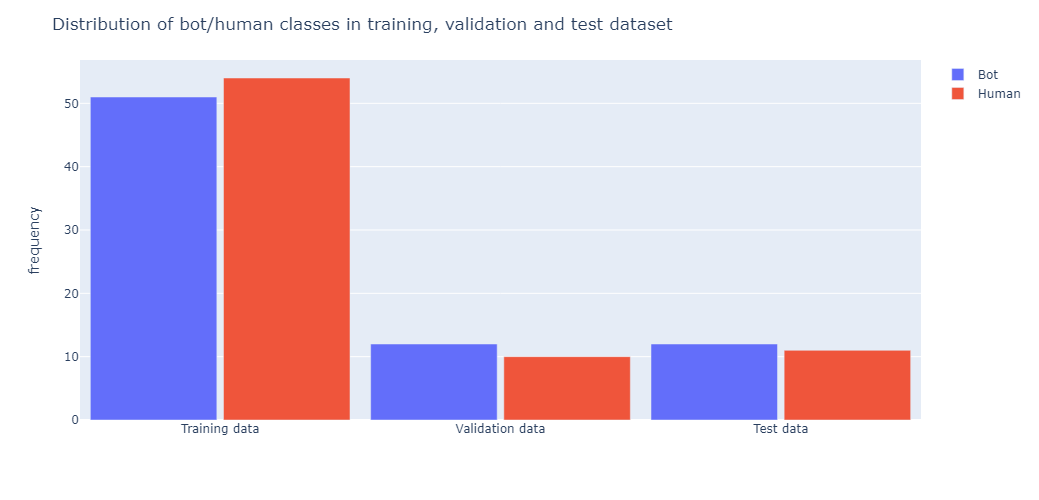

In [80]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [84]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*8 + ['Human']*8,
    'Value': [True]*4 + [False]*4 + [True]*4 + [False]*4,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             # len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             # len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

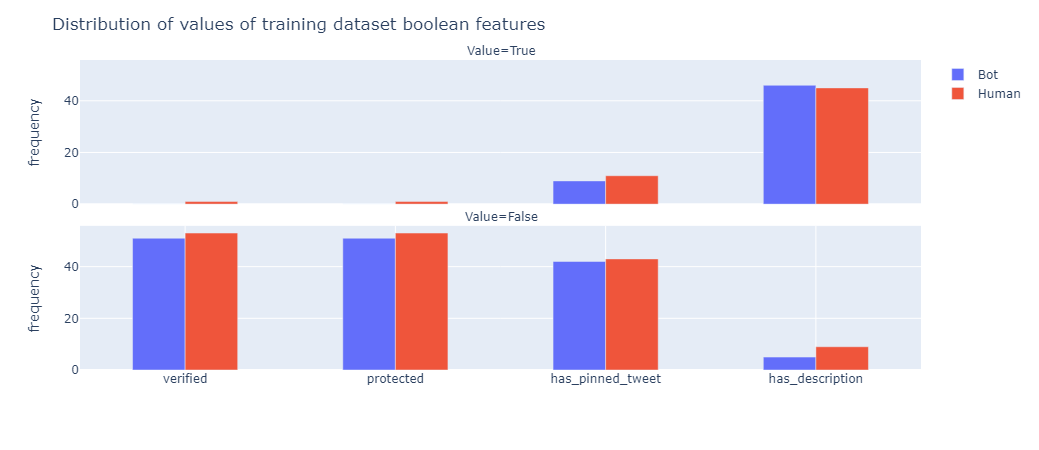

In [85]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

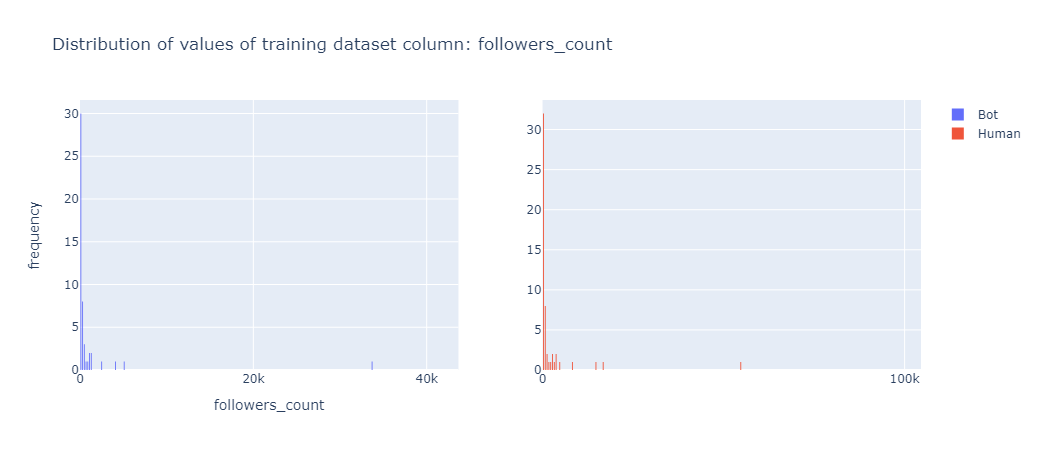

In [86]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000, range=[0, max(train_data.loc[train_data['label']==1,'followers_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=100000, range=[0, max(train_data.loc[train_data['label']==0,'followers_count'])+50000]),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  33


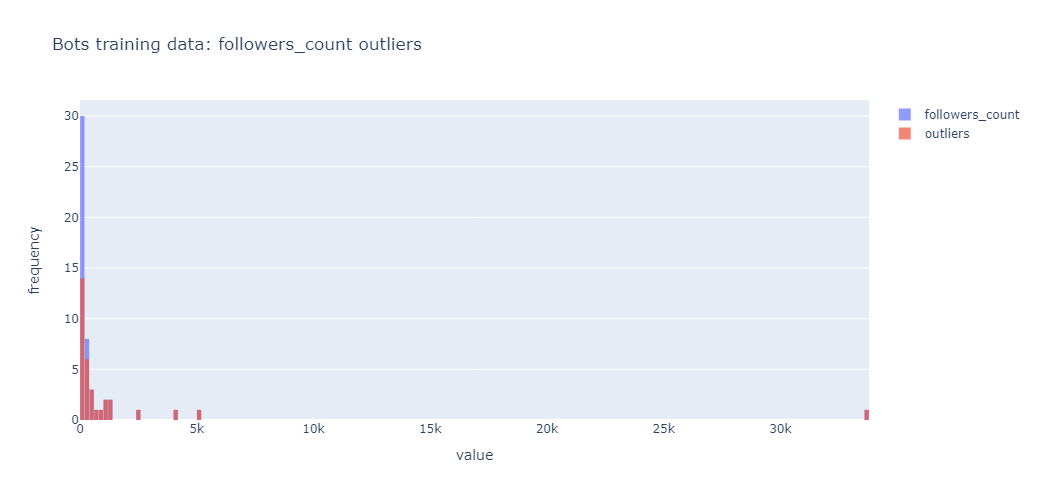

<Figure size 1500x700 with 0 Axes>

In [87]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  22


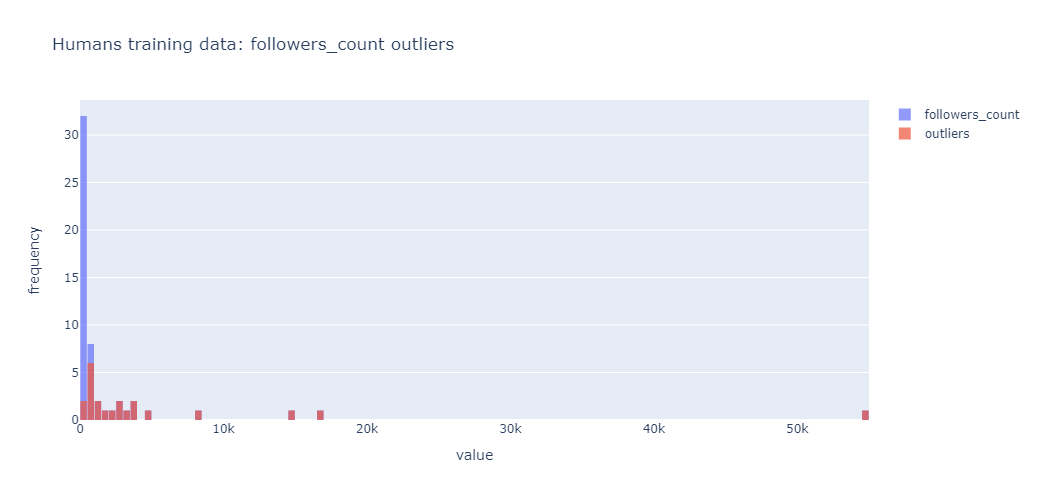

<Figure size 1500x700 with 0 Axes>

In [88]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [89]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [90]:
len(train_data[(train_data['label']==1)])

51

In [91]:
len(train_data[(train_data['label']==0)])

54

In [92]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [93]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [94]:
len(df_filtered_bots)

49

In [95]:
len(df_filtered_humans)

51

In [96]:
len(df_reduced_outliers_followers_count) 

100

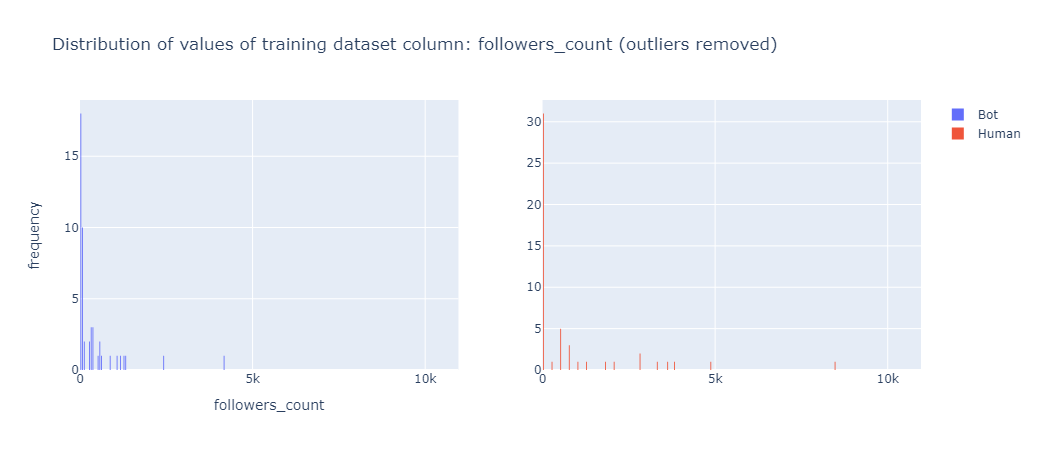

In [97]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

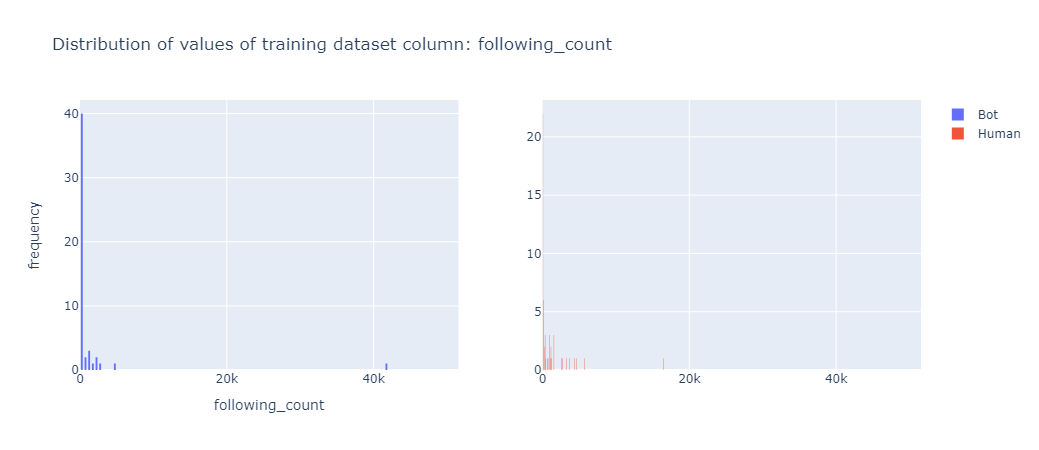

In [98]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [99]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

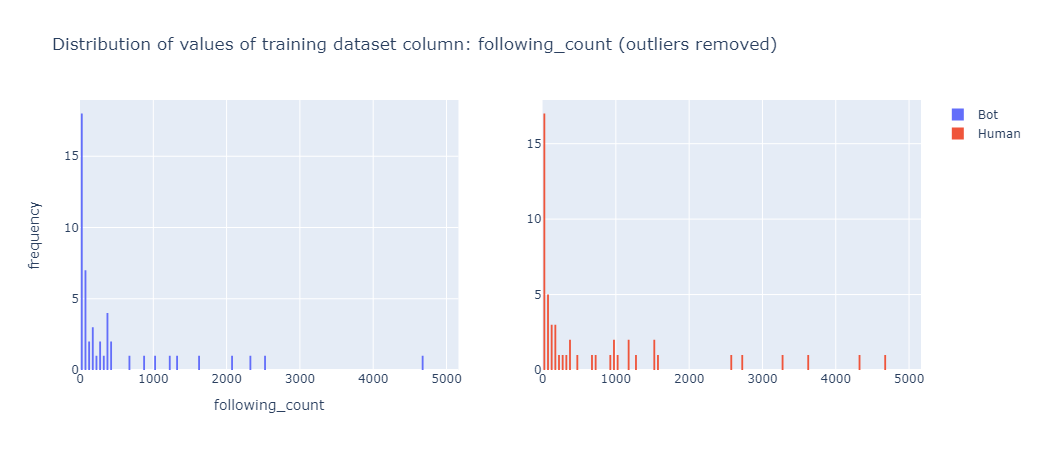

In [100]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

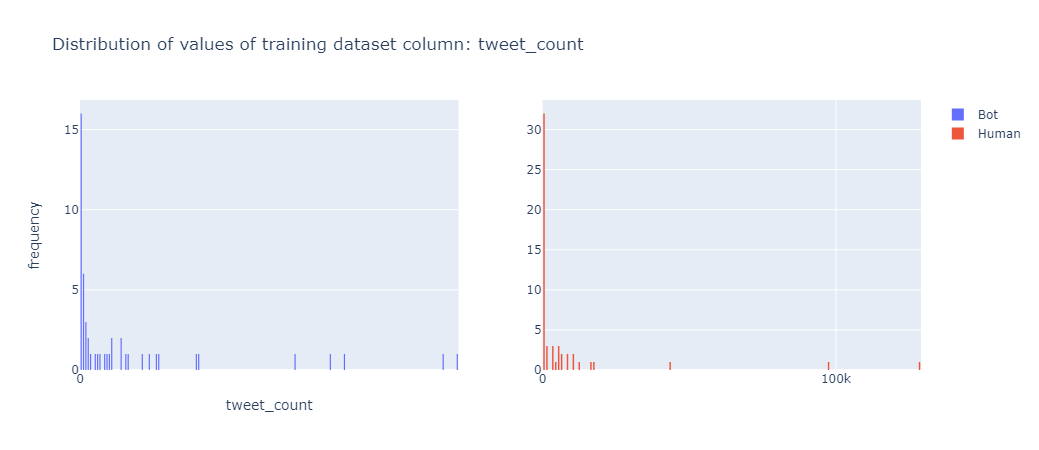

In [101]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [102]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

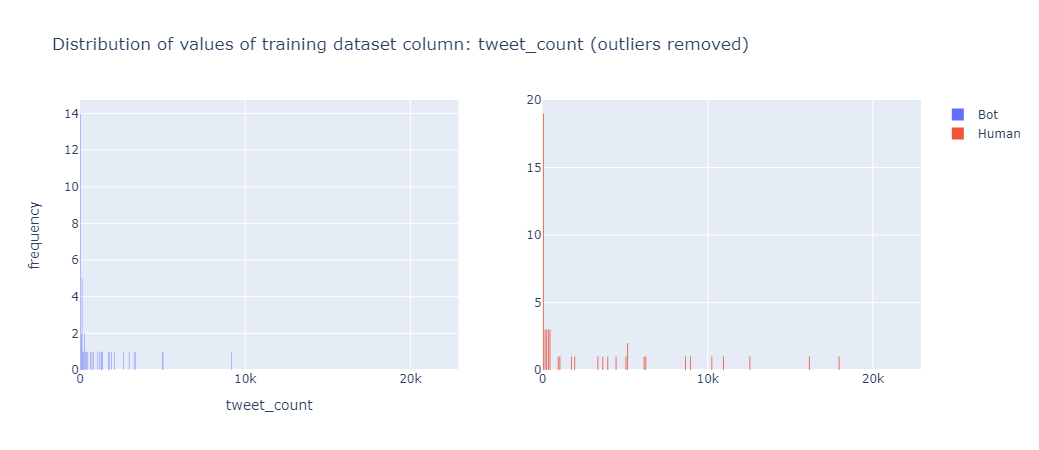

In [103]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    xaxis2=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

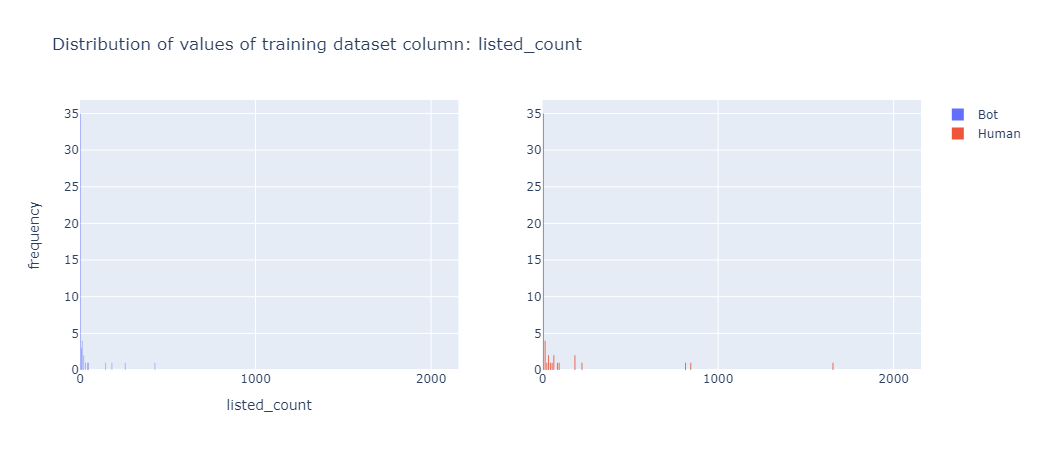

In [104]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [105]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

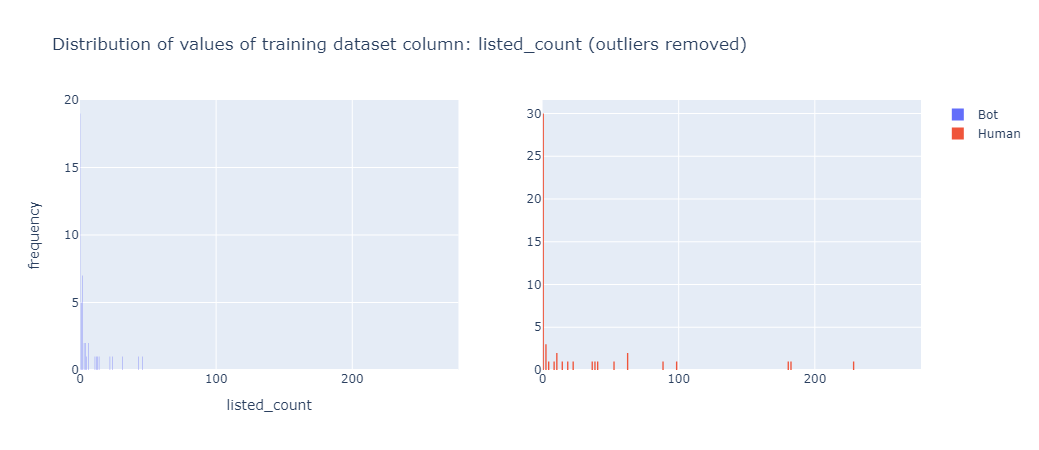

In [106]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    xaxis2=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

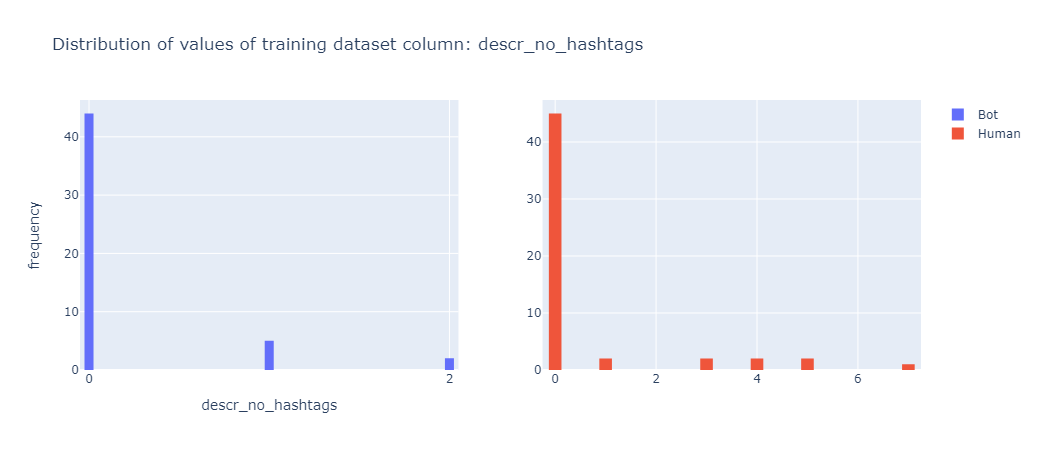

In [107]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [108]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

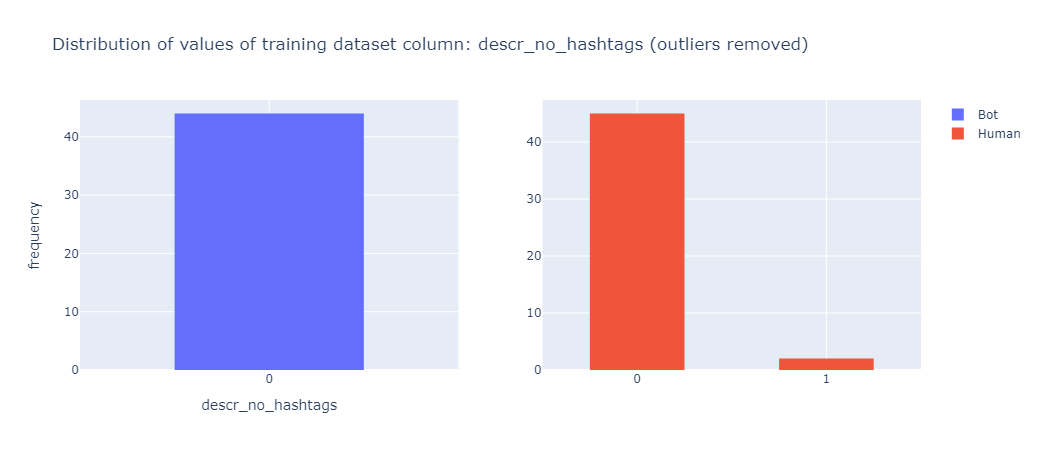

In [109]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


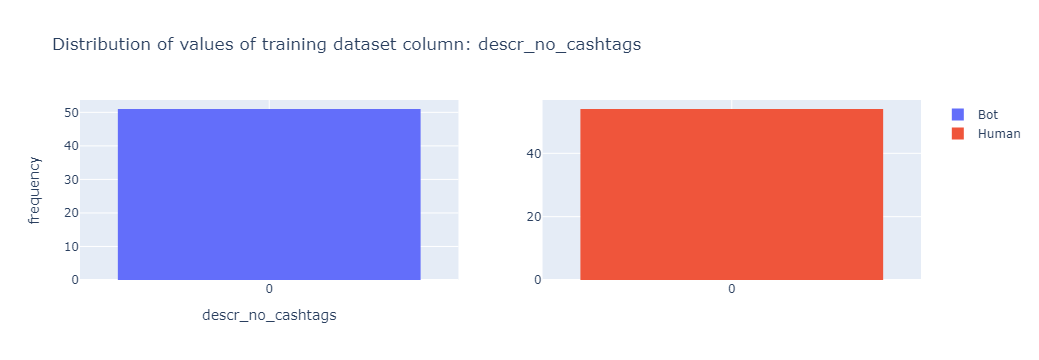

In [110]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [111]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



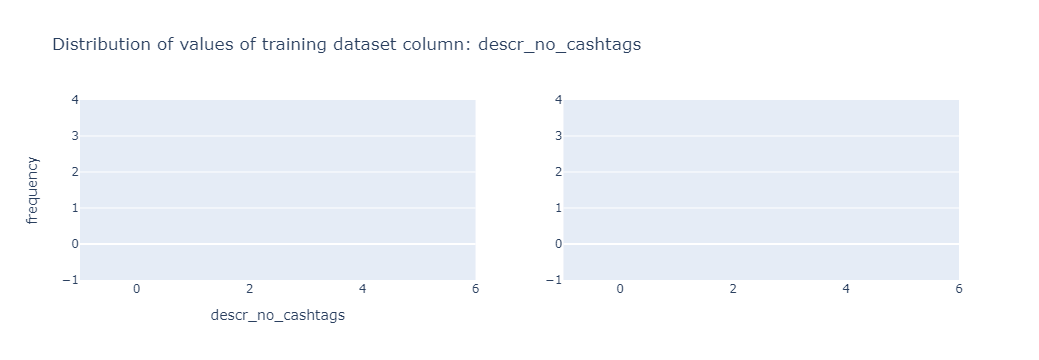

In [112]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1),
    # xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

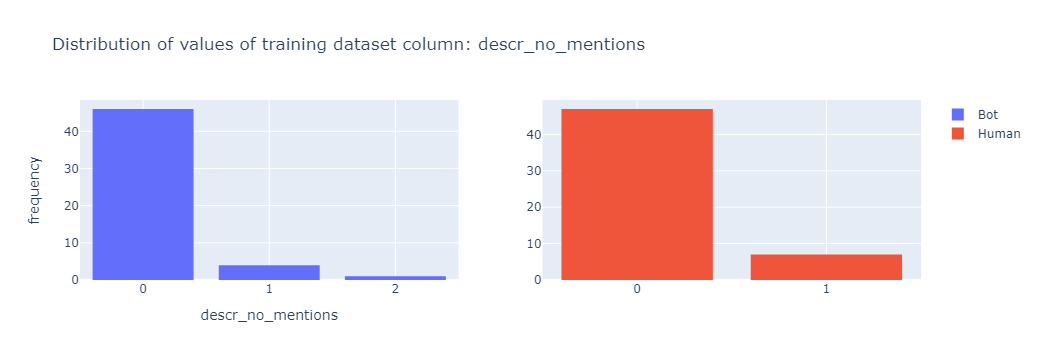

In [113]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [114]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

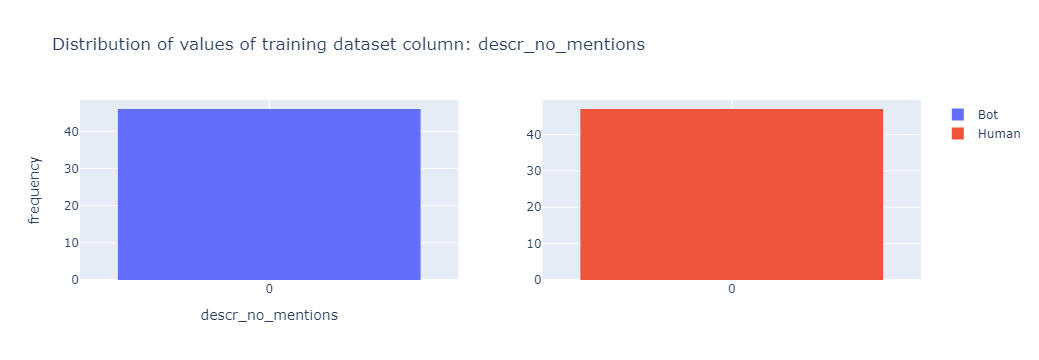

In [115]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

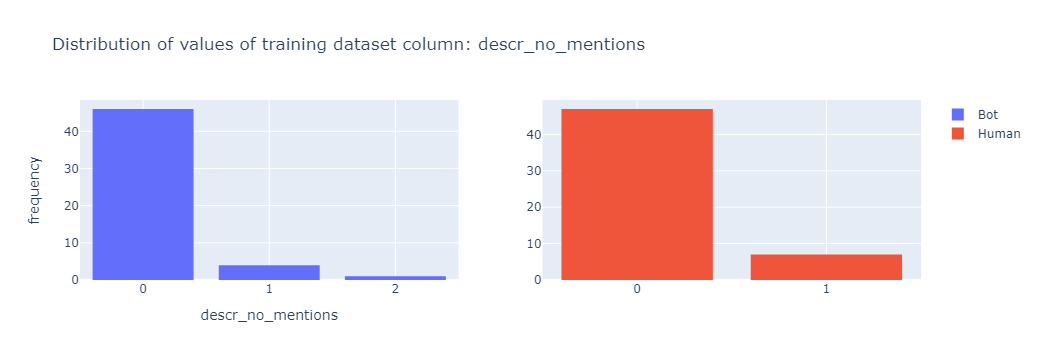

In [116]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [117]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

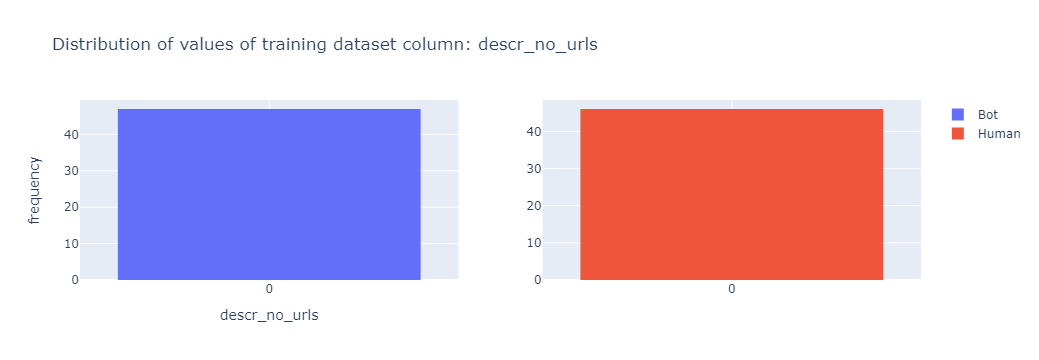

In [118]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

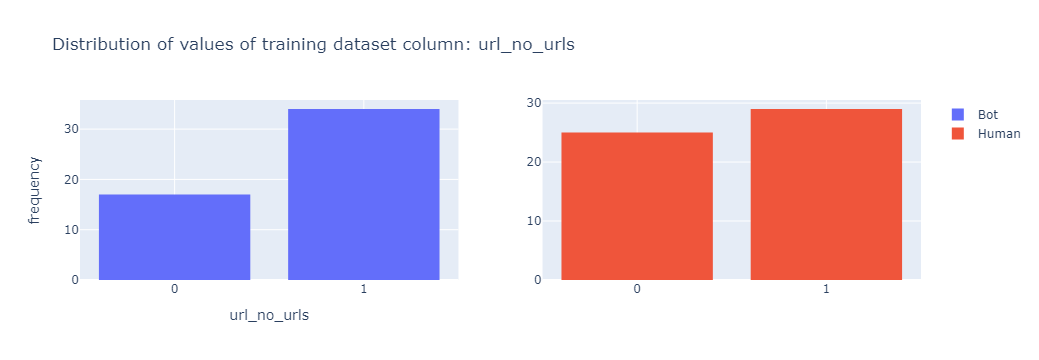

In [119]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [120]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

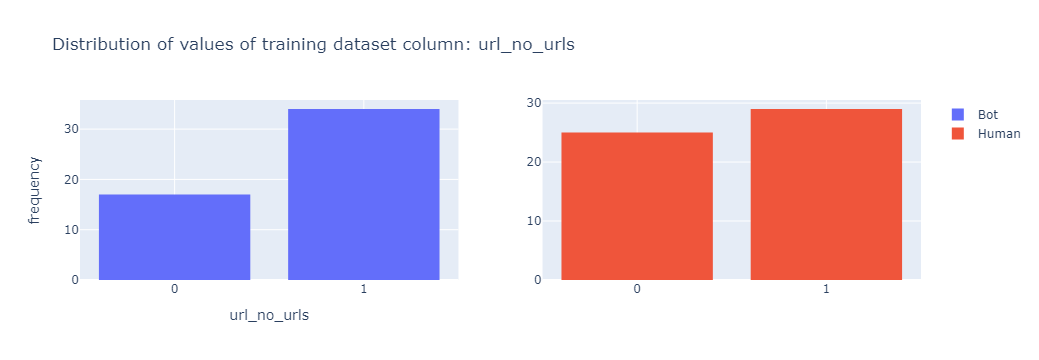

In [121]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

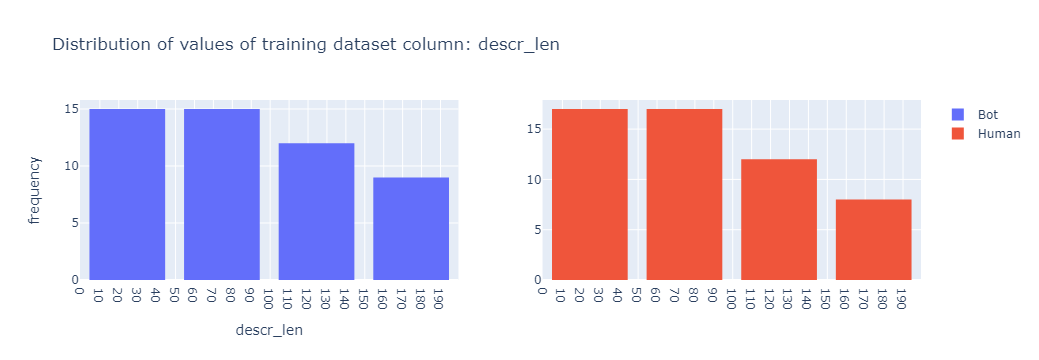

In [122]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [123]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

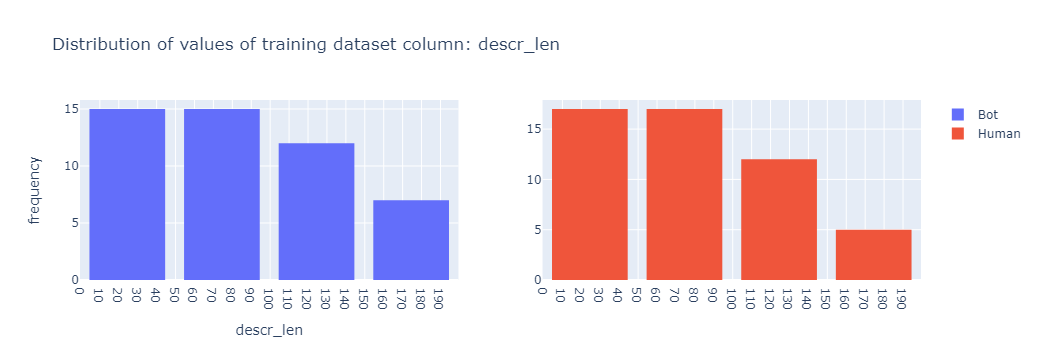

In [124]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

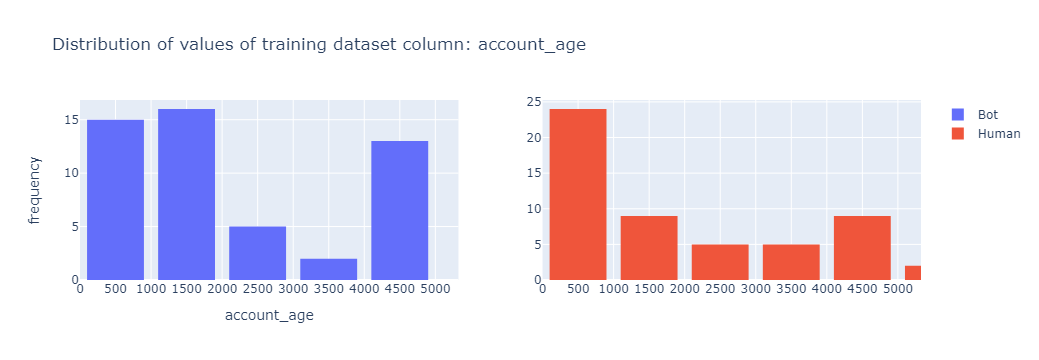

In [125]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [126]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

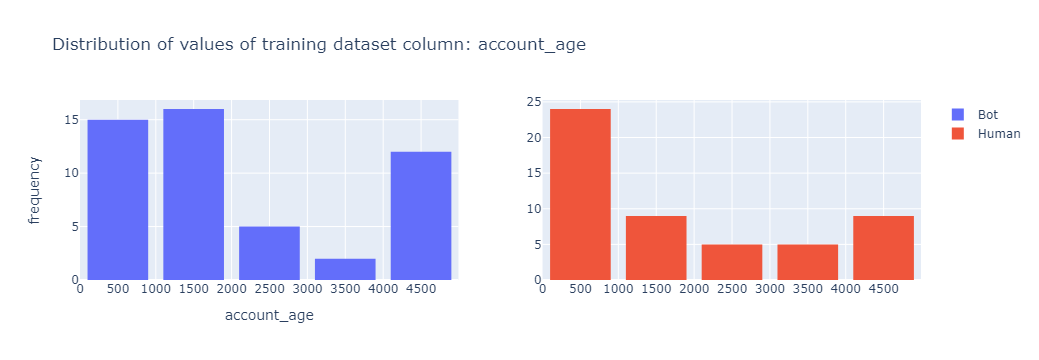

In [127]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [128]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [129]:
len(train_data)

105

In [130]:
len(train_data_wo_outliers)

64

In [131]:
train_data_wo_outliers

id  label  verified  protected  has_pinned_tweet  \
0   1.339962e+08    1.0       0.0        0.0               0.0   
1   2.326062e+08    0.0       0.0        0.0               0.0   
2   9.630865e+17    1.0       0.0        0.0               0.0   
3   7.381117e+17    0.0       0.0        0.0               0.0   
4   6.337677e+08    0.0       0.0        0.0               0.0   
5   8.825649e+17    1.0       0.0        0.0               0.0   
6   4.155542e+09    0.0       0.0        0.0               0.0   
7   5.078825e+07    1.0       0.0        0.0               0.0   
8   9.083284e+08    0.0       0.0        0.0               0.0   
9   2.592955e+08    1.0       0.0        0.0               0.0   
10  1.098981e+18    0.0       0.0        0.0               0.0   
11  8.692522e+17    1.0       0.0        0.0               0.0   
12  1.098046e+18    1.0       0.0        0.0               0.0   
13  1.242475e+18    0.0       0.0        0.0               0.0   
14  4.545098e+08    0.0       0.0        0.0               0.0   
15  1.388214e+18    1.0       0.0        0.0               0.0   
16  1.020271e+18    1.0       0.0        0.0               0.0   
17  1.401299e+09    0.0       0.0        0.0               0.0   
18  1.329634e+18    0.0       0.0        0.0               1.0   
19  1.478792e+18    0.0       0.0        0.0               0.0   
20  8.971595e+17    0.0       0.0        0.0               0.0   
21  1.259796e+18    1.0       0.0        0.0               0.0   
22  1.391779e+18    0.0       0.0        0.0               0.0   
23  3.895626e+08    1.0       0.0        0.0               0.0   
24  1.256378e+18    1.0       0.0        0.0               1.0   
25  1.276840e+18    0.0       0.0        0.0               0.0   
26  3.613737e+07    0.0       0.0        0.0               1.0   
27  4.646854e+07    1.0       0.0        0.0               0.0   
28  1.327565e+18    0.0       0.0        0.0               1.0   
29  1.409989e+18    1.0       0.0        0.0               0.0   
30  1.205275e+18    0.0       0.0        0.0               0.0   
31  1.374022e+18    0.0       0.0        0.0               0.0   
32  1.463754e+18    0.0       0.0        0.0               0.0   
33  1.481891e+18    0.0       0.0        0.0               0.0   
34  1.072095e+18    1.0       0.0        0.0               0.0   
35  4.378488e+09    1.0       0.0        0.0               0.0   
36  8.868775e+17    0.0       0.0        0.0               0.0   
37  2.288796e+09    1.0       0.0        0.0               0.0   
38  1.393273e+18    0.0       0.0        0.0               0.0   
39  1.164284e+18    0.0       0.0        1.0               0.0   
40  1.297952e+18    0.0       0.0        0.0               0.0   
41  1.282536e+18    1.0       0.0        0.0               0.0   
42  1.487790e+18    0.0       0.0        0.0               0.0   
43  8.422021e+17    1.0       0.0        0.0               0.0   
44  1.197150e+18    1.0       0.0        0.0               0.0   
45  8.781038e+17    1.0       0.0        0.0               0.0   
46  2.332454e+09    1.0       0.0        0.0               0.0   
47  2.587037e+08    0.0       0.0        0.0               0.0   
48  1.279726e+18    1.0       0.0        0.0               0.0   
49  1.298948e+18    1.0       0.0        0.0               0.0   
50  9.235606e+17    0.0       0.0        0.0               0.0   
51  8.825719e+07    0.0       0.0        0.0               0.0   
52  1.107627e+18    1.0       0.0        0.0               1.0   
53  4.591699e+08    1.0       0.0        0.0               1.0   
54  1.273293e+18    1.0       0.0        0.0               1.0   
55  2.707806e+07    1.0       0.0        0.0               0.0   
56  1.463139e+18    1.0       0.0        0.0               0.0   
57  1.484544e+18    0.0       0.0        0.0               0.0   
58  2.895227e+09    0.0       0.0        0.0               0.0   
59  1.878592e+08    1.0       0.0        0.0          

#### Drop 'id' column

In [132]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [133]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  51
Number of human users:  51
Number of bots:  10
Number of human users:  10
Number of bots:  11
Number of human users:  11


In [134]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  30
Number of human users:  30
Number of bots:  10
Number of human users:  10
Number of bots:  11
Number of human users:  11


#### First drop columns in dataframes where there are same value in whole columns in training dataset

In [135]:
same_data_columns = list(train_data.columns[train_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

['descr_no_cashtags']

In [136]:
train_data = train_data.drop(same_data_columns, axis=1)

val_data = val_data.drop(same_data_columns, axis=1)
test_data = test_data.drop(same_data_columns, axis=1)

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [137]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['verified', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls']

In [138]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

## Correlation

In [139]:
sns.set(font_scale=2.5)

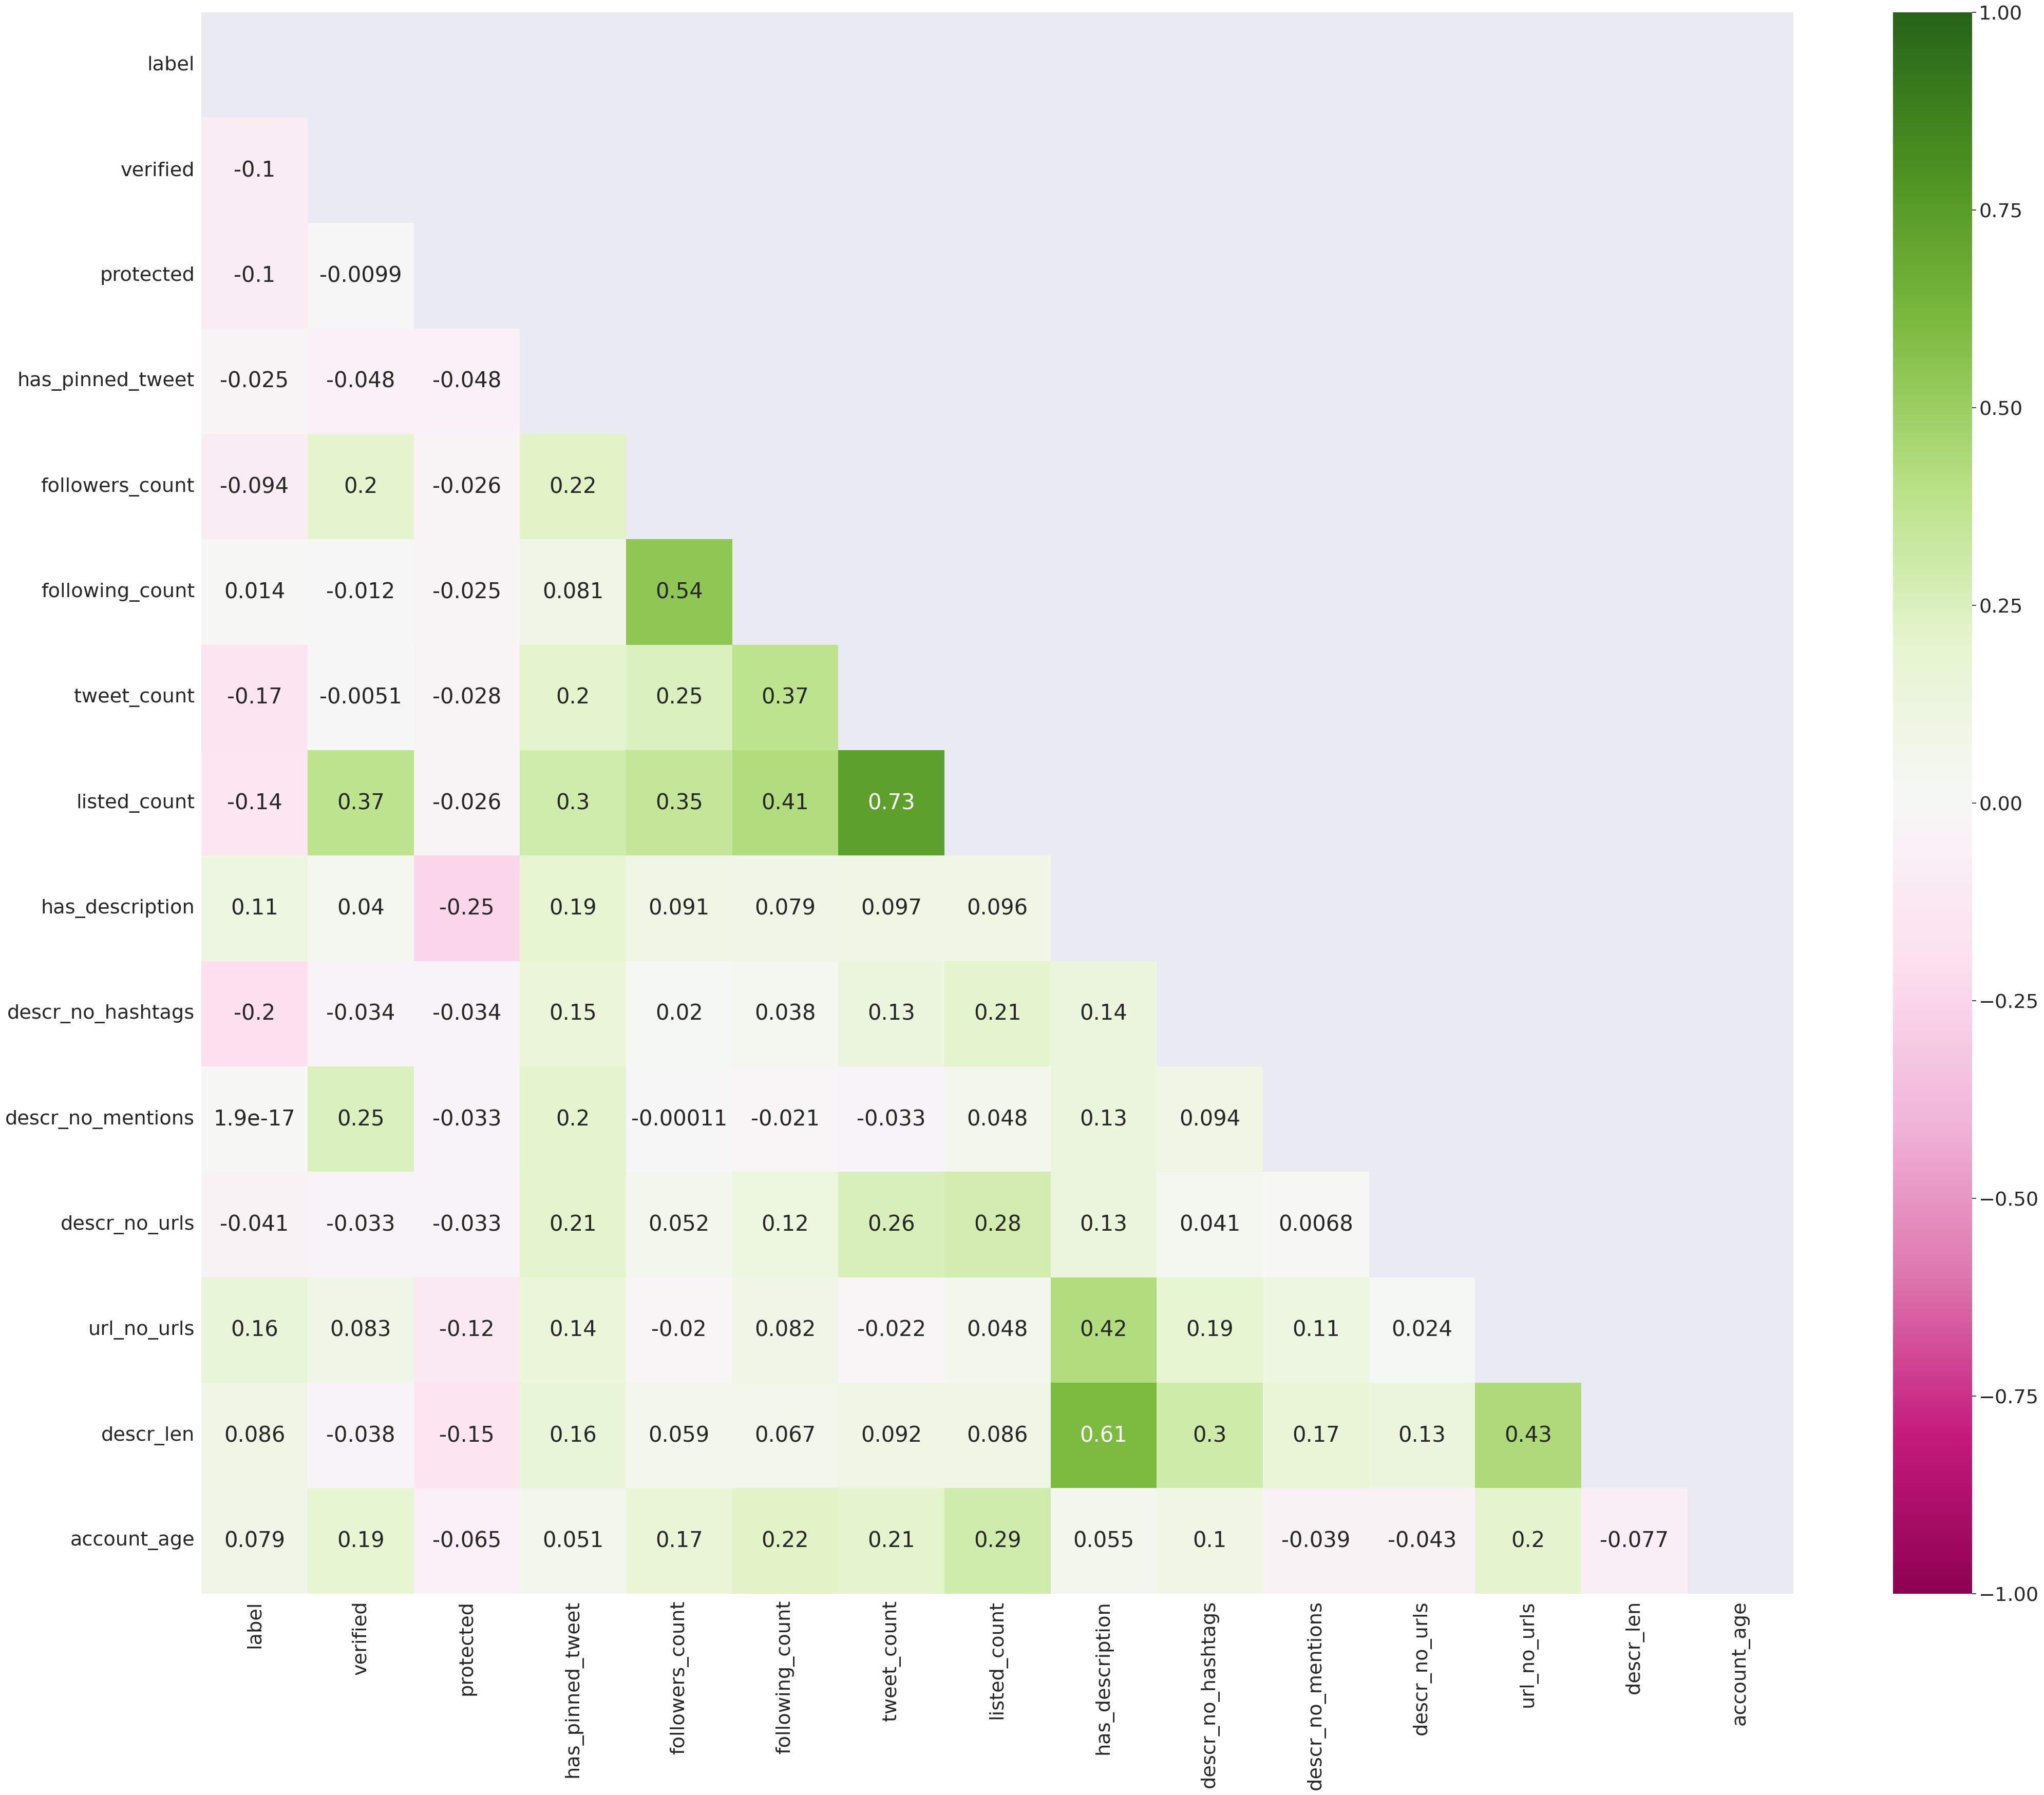

In [140]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [141]:
sns.set(font_scale=1)

In [142]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 3


[('tweet_count', 'listed_count', 0.7293885889943222),
 ('has_description', 'descr_len', 0.6056919939283111),
 ('followers_count', 'following_count', 0.5439451001412743)]

In [143]:
train_data

label  verified  protected  has_pinned_tweet  followers_count  \
10     1.0       0.0        0.0               0.0            517.0   
33     0.0       0.0        0.0               0.0              5.0   
78     1.0       0.0        0.0               0.0           1065.0   
27     0.0       0.0        0.0               0.0              4.0   
121    0.0       0.0        0.0               0.0             22.0   
..     ...       ...        ...               ...              ...   
89     0.0       0.0        0.0               0.0             13.0   
136    1.0       0.0        0.0               0.0            623.0   
118    1.0       0.0        0.0               1.0           4180.0   
62     1.0       0.0        0.0               0.0            285.0   
132    1.0       0.0        0.0               0.0            363.0   

     following_count  tweet_count  listed_count  has_description  \
10             414.0        303.0           2.0              1.0   
33              38.0          6.0           0.0              0.0   
78             687.0       2094.0           3.0              1.0   
27             159.0          8.0           0.0              1.0   
121             57.0        980.0           0.0              1.0   
..               ...          ...           ...              ...   
89              67.0          1.0           0.0              1.0   
136              2.0       1187.0           2.0              1.0   
118           2541.0      11245.0         425.0              1.0   
62            1237.0       3382.0           5.0              1.0   
132            289.0       1282.0          31.0              1.0   

     descr_no_hashtags  descr_no_mentions  descr_no_urls  url_no_urls  \
10                 0.0                0.0            0.0          1.0   
33                 0.0                0.0            0.0          0.0   
78                 0.0                0.0            0.0          1.0   
27                 0.0                0.0            0.0          0.0   
121                0.0                0.0            0.0          0.0   
..                 ...                ...            ...          ...   
89                 0.0                0.0            0.0          1.0   
136                1.0                0.0            0.0          1.0   
118                0.0                0.0            0.0          1.0   
62                 1.0                0.0            0.0          1.0   
132                0.0                1.0            0.0          1.0   

     descr_len  account_age  
10       159.0       4351.0  
33         0.0       4093.0  
78       151.0       1493.0  
27        62.0       2114.0  
121       77.0       3534.0  
..         ...          ...  
89        73.0        648.0  
136      107.0       1429.0  
118       99.0       4683.0  
62       160.0        610.0  
132      107.0       4697.0  

[102 rows x 15 columns]

In [144]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

# train_data = train_data.drop(['has_location'], axis=1)
# val_data = val_data.drop(['has_location'], axis=1)
# test_data = test_data.drop(['has_location'], axis=1)

### Correlation of data reduced by outliers

#### Correlation

In [145]:
sns.set(font_scale=2)

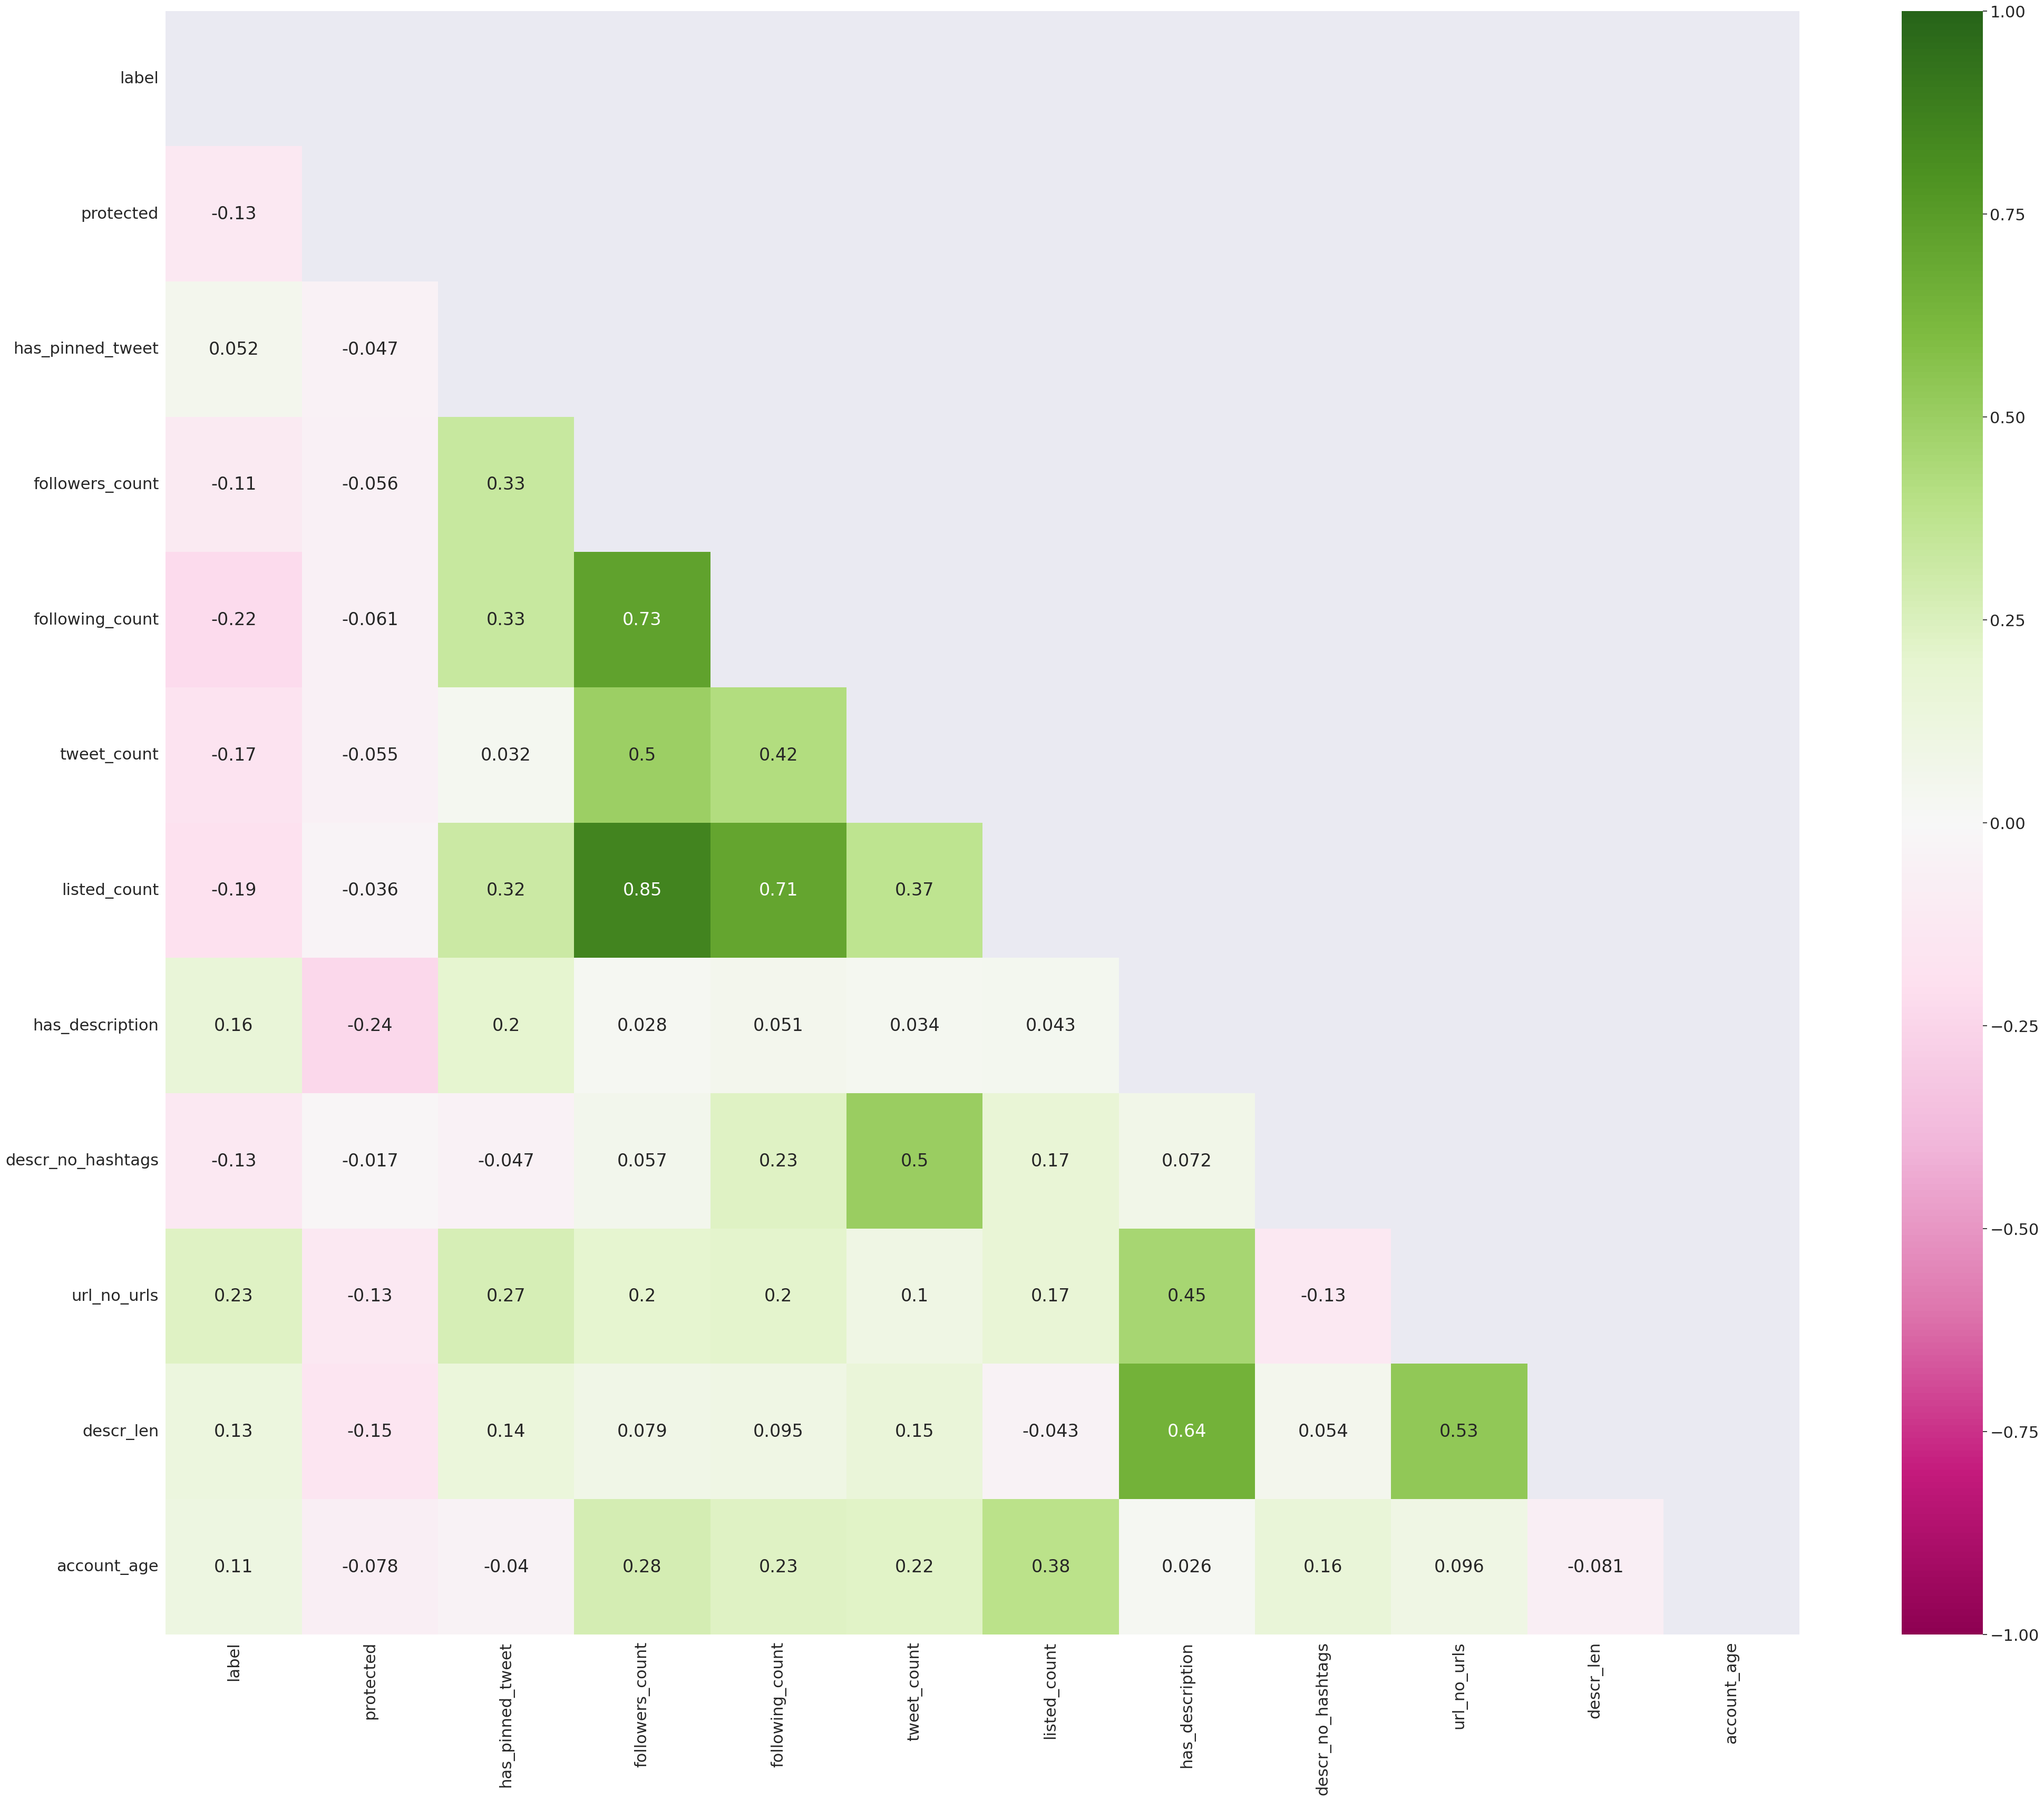

In [146]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [147]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [148]:
high_corr2

[('followers_count', 'listed_count', 0.8520603452683754),
 ('followers_count', 'following_count', 0.725038133259905),
 ('following_count', 'listed_count', 0.7051391757212209),
 ('has_description', 'descr_len', 0.6432746527492508),
 ('url_no_urls', 'descr_len', 0.534959217813274)]

In [149]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description',  'url_no_urls'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [150]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [151]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [152]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [153]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [154]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [155]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [156]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-27 17:26:40.790166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 17:26:40.790212: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-27 17:26:40.790246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (29f454065ebb): /proc/driver/nvidia/version does not exist
2023-08-27 17:26:40.791526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=300

#### Create and train model

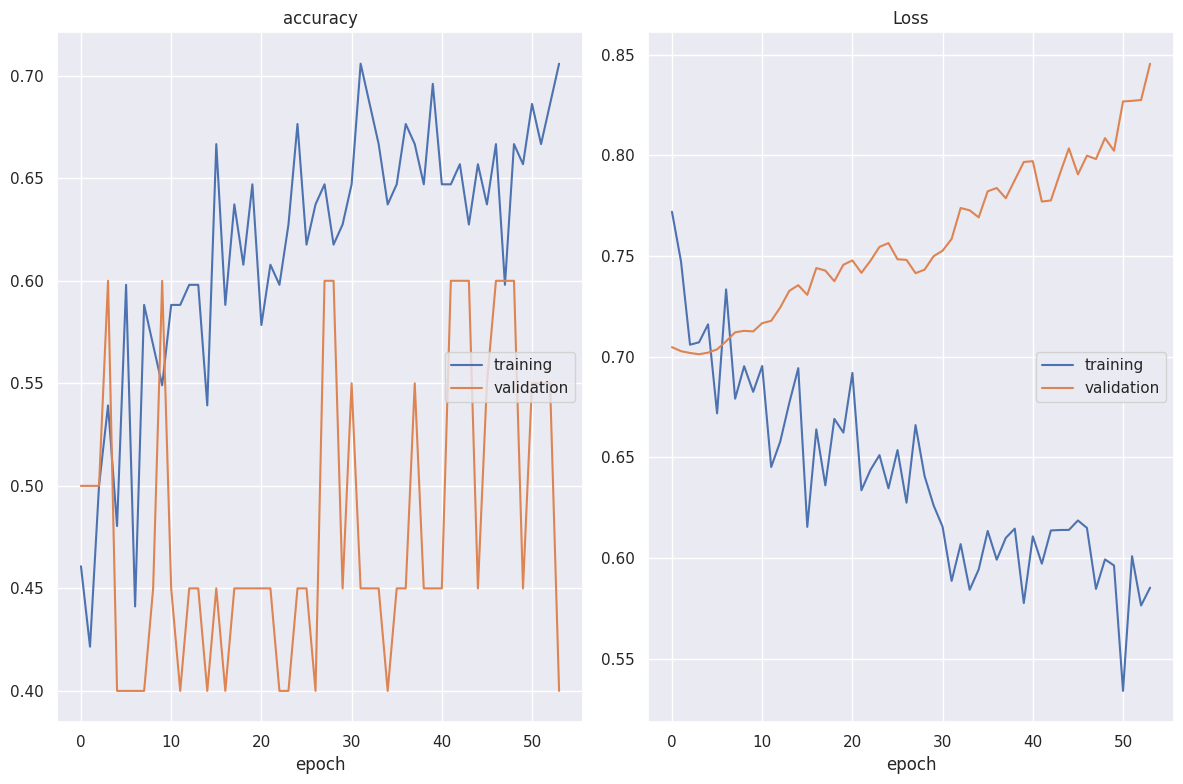

accuracy
	training         	 (min:    0.422, max:    0.706, cur:    0.706)
	validation       	 (min:    0.400, max:    0.600, cur:    0.400)
Loss
	training         	 (min:    0.534, max:    0.772, cur:    0.585)
	validation       	 (min:    0.701, max:    0.846, cur:    0.846)

Epoch 54: val_accuracy did not improve from 0.60000
11/11 [==============================] - 1s 57ms/step - loss: 0.5853 - accuracy: 0.7059 - val_loss: 0.8455 - val_accuracy: 0.4000


In [157]:
model_name = 'model_users_only_150_1_v1_batch_size_10'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.45454545454545453
Precision: [0.47619048 0.        ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.454545


(0.45454545454545453,
 array([0.47619048, 0.        ]),
 0.0,
 0.0,
 0.45454545454545453)

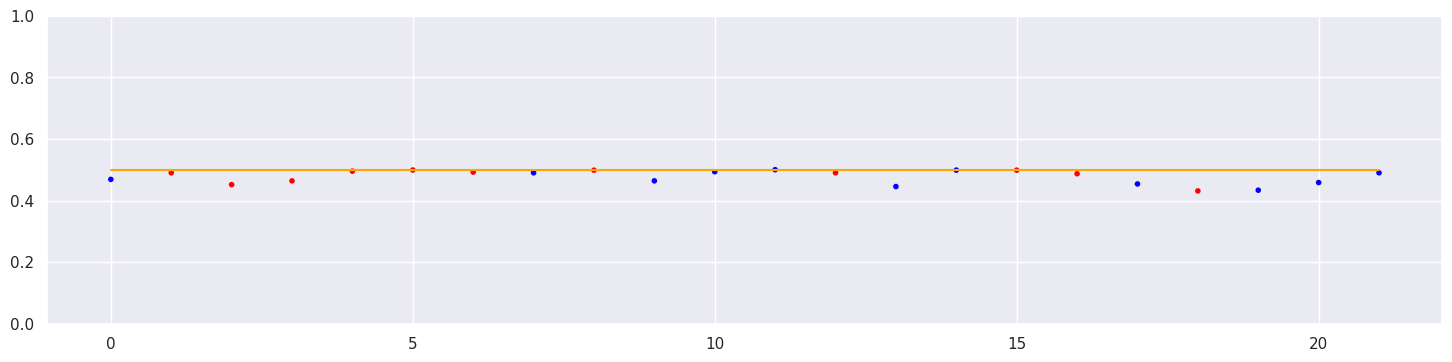

<Figure size 640x480 with 0 Axes>

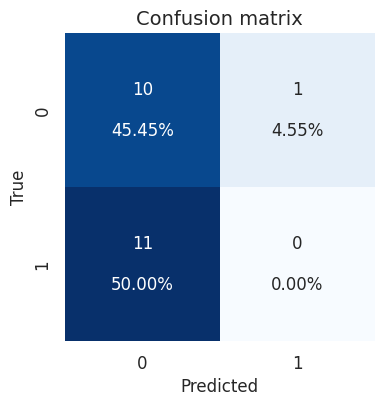

In [158]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=300

In [194]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 32)                416       
                                                                 
 dense_66 (Dense)            (None, 32)                1056      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 64)                2112      
                                                                 
 dense_68 (Dense)            (None, 64)                4160      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 1)               

### Train model

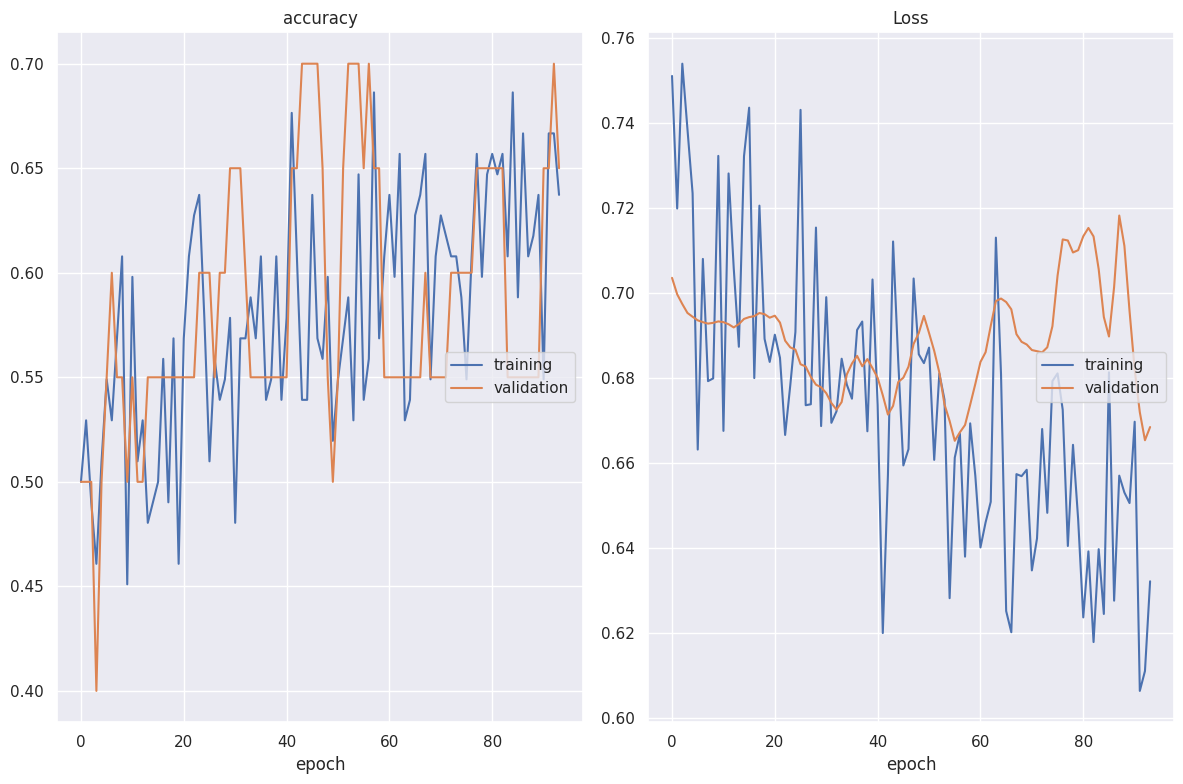

accuracy
	training         	 (min:    0.451, max:    0.686, cur:    0.637)
	validation       	 (min:    0.400, max:    0.700, cur:    0.650)
Loss
	training         	 (min:    0.606, max:    0.754, cur:    0.632)
	validation       	 (min:    0.665, max:    0.718, cur:    0.669)

Epoch 94: val_accuracy did not improve from 0.70000
3/3 [==============================] - 1s 274ms/step - loss: 0.6322 - accuracy: 0.6373 - val_loss: 0.6685 - val_accuracy: 0.6500


In [195]:
model_name = 'model_users_only_150_1_v1_batch_size_50'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=300)

In [196]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [197]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

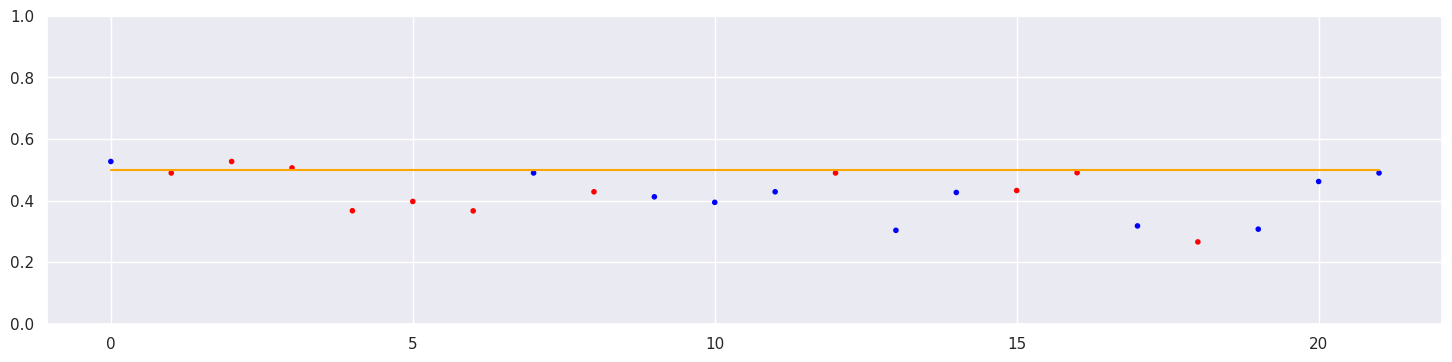

In [198]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.5454545454545454
Precision: [0.52631579 0.66666667]
Recall: 0.18181818181818182
F1 score: 0.285714
ROC AUC: 0.545455


(0.5454545454545454,
 array([0.52631579, 0.66666667]),
 0.18181818181818182,
 0.28571428571428575,
 0.5454545454545454)

<Figure size 640x480 with 0 Axes>

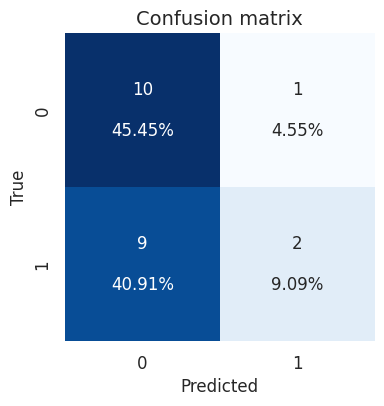

In [199]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=300

#### Create and train model

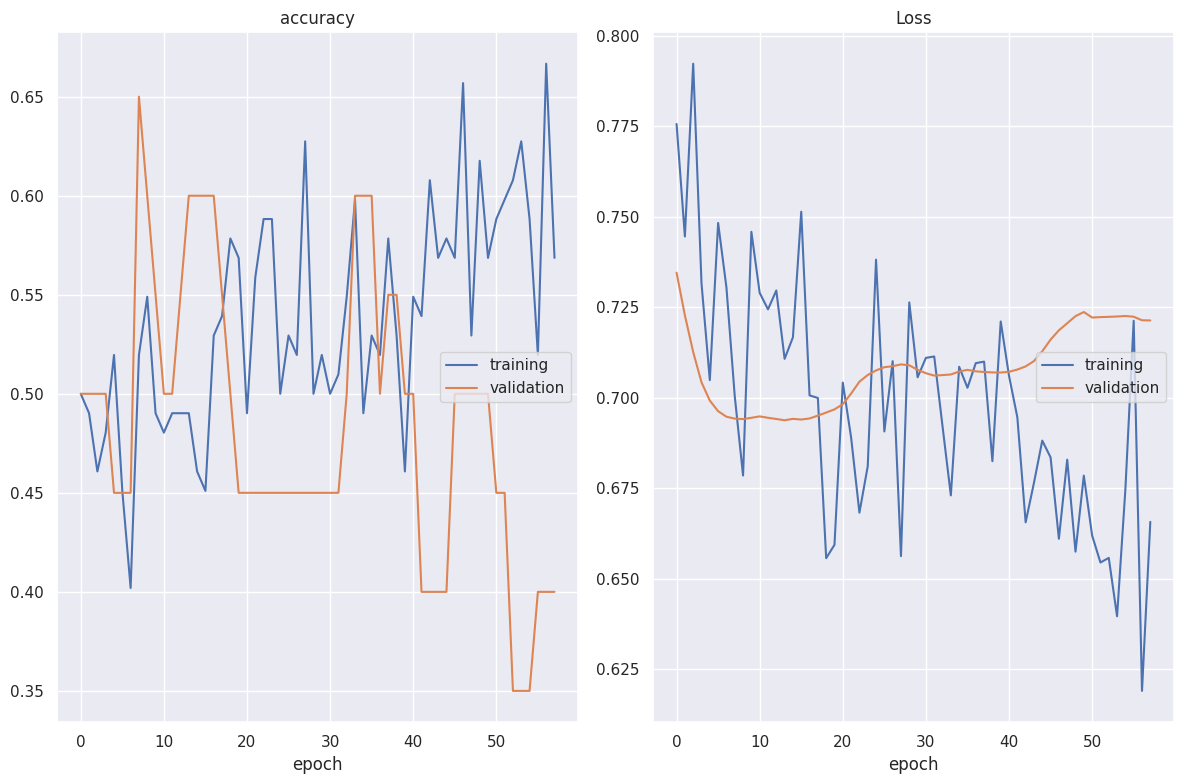

accuracy
	training         	 (min:    0.402, max:    0.667, cur:    0.569)
	validation       	 (min:    0.350, max:    0.650, cur:    0.400)
Loss
	training         	 (min:    0.619, max:    0.792, cur:    0.666)
	validation       	 (min:    0.694, max:    0.735, cur:    0.721)

Epoch 58: val_accuracy did not improve from 0.65000
2/2 [==============================] - 1s 550ms/step - loss: 0.6657 - accuracy: 0.5686 - val_loss: 0.7214 - val_accuracy: 0.4000


In [165]:
model_name = 'model_users_only_150_1_v1_batch_size_100'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.45454545454545453
Precision: [0.47058824 0.4       ]
Recall: 0.18181818181818182
F1 score: 0.250000
ROC AUC: 0.454545


(0.45454545454545453,
 array([0.47058824, 0.4       ]),
 0.18181818181818182,
 0.25000000000000006,
 0.45454545454545453)

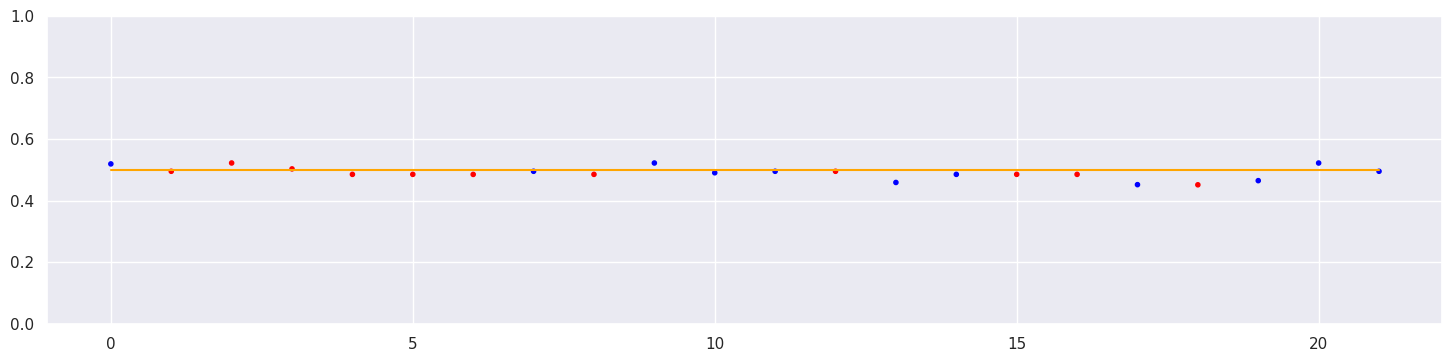

<Figure size 640x480 with 0 Axes>

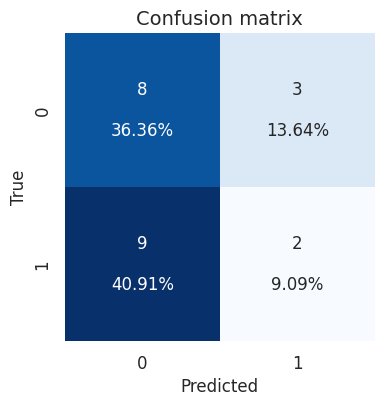

In [166]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=300

#### Create and train model

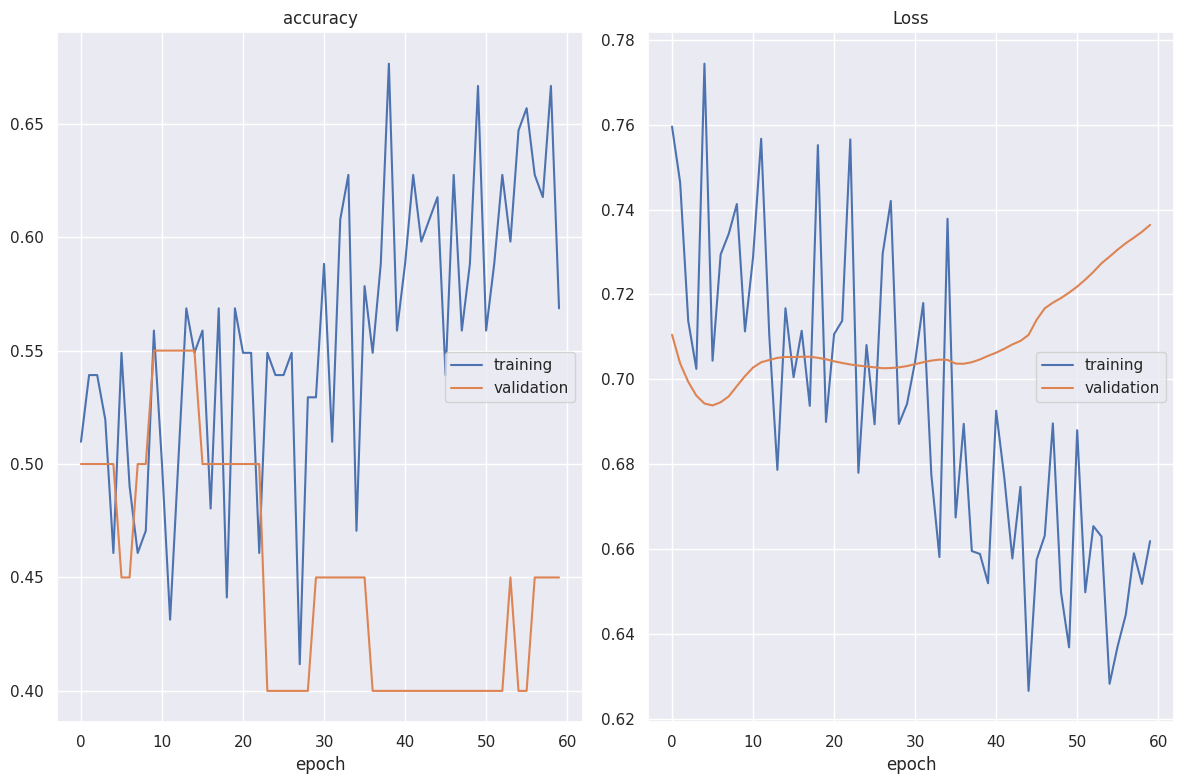

accuracy
	training         	 (min:    0.412, max:    0.676, cur:    0.569)
	validation       	 (min:    0.400, max:    0.550, cur:    0.450)
Loss
	training         	 (min:    0.627, max:    0.774, cur:    0.662)
	validation       	 (min:    0.694, max:    0.736, cur:    0.736)

Epoch 60: val_accuracy did not improve from 0.55000
1/1 [==============================] - 1s 559ms/step - loss: 0.6619 - accuracy: 0.5686 - val_loss: 0.7364 - val_accuracy: 0.4500


In [167]:
model_name = 'model_users_only_150_1_v1_batch_size_150'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.45454545454545453
Precision: [0.33333333 0.47368421]
Recall: 0.8181818181818182
F1 score: 0.600000
ROC AUC: 0.454545


(0.45454545454545453,
 array([0.33333333, 0.47368421]),
 0.8181818181818182,
 0.6,
 0.4545454545454546)

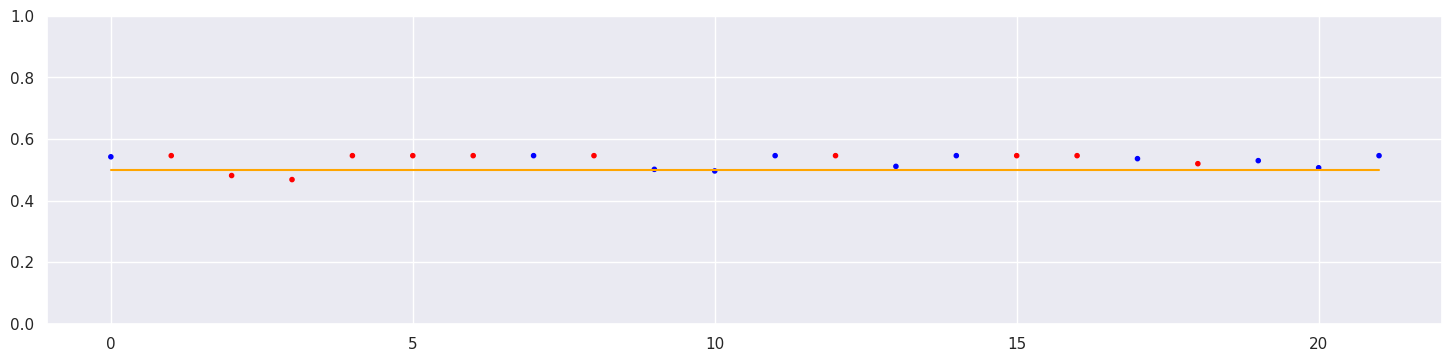

<Figure size 640x480 with 0 Axes>

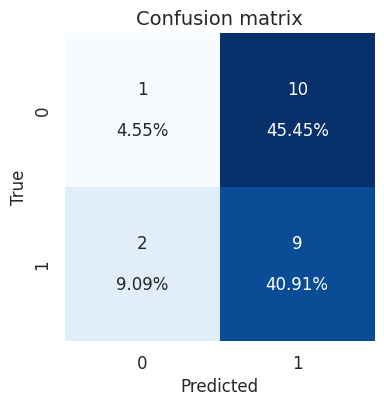

In [168]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=300

#### Create and train model

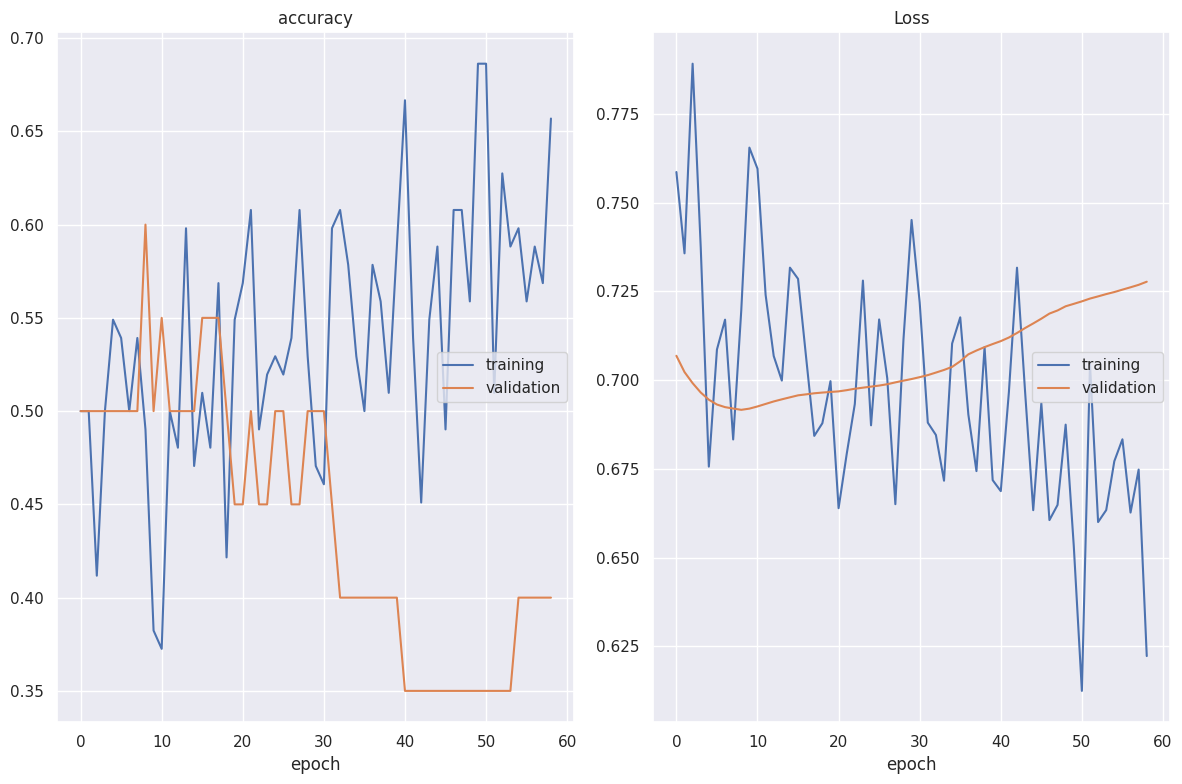

accuracy
	training         	 (min:    0.373, max:    0.686, cur:    0.657)
	validation       	 (min:    0.350, max:    0.600, cur:    0.400)
Loss
	training         	 (min:    0.612, max:    0.789, cur:    0.622)
	validation       	 (min:    0.692, max:    0.728, cur:    0.728)

Epoch 59: val_accuracy did not improve from 0.60000
1/1 [==============================] - 1s 552ms/step - loss: 0.6223 - accuracy: 0.6569 - val_loss: 0.7277 - val_accuracy: 0.4000


In [200]:
model_name = 'model_users_only_150_1_v1_batch_size_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.4090909090909091
Precision: [0.45 0.  ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.409091


(0.4090909090909091, array([0.45, 0.  ]), 0.0, 0.0, 0.40909090909090906)

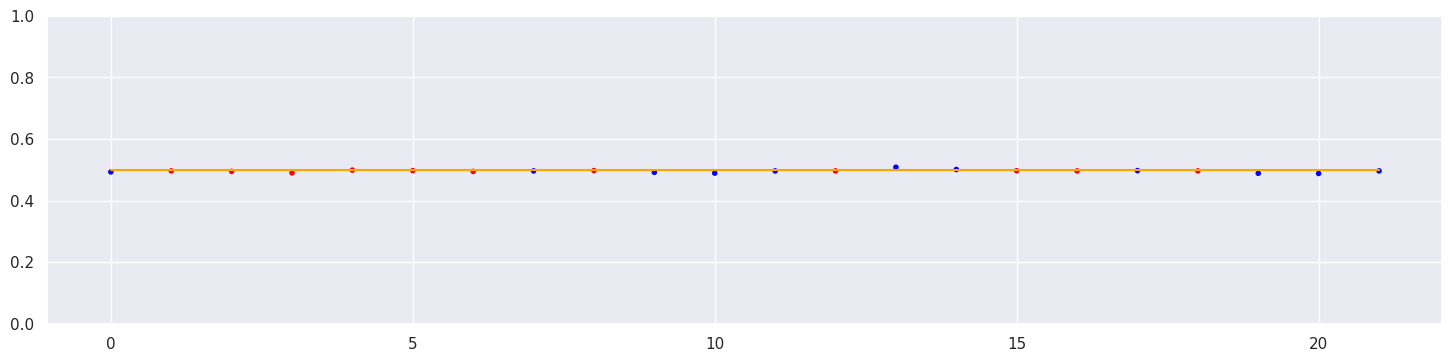

<Figure size 640x480 with 0 Axes>

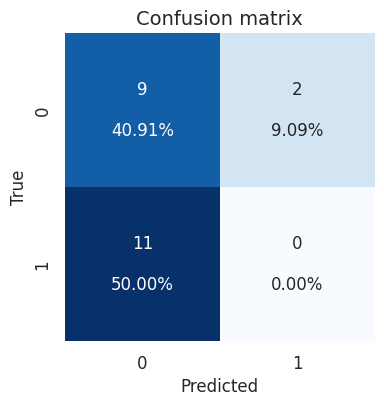

In [201]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=300

#### Create and train model

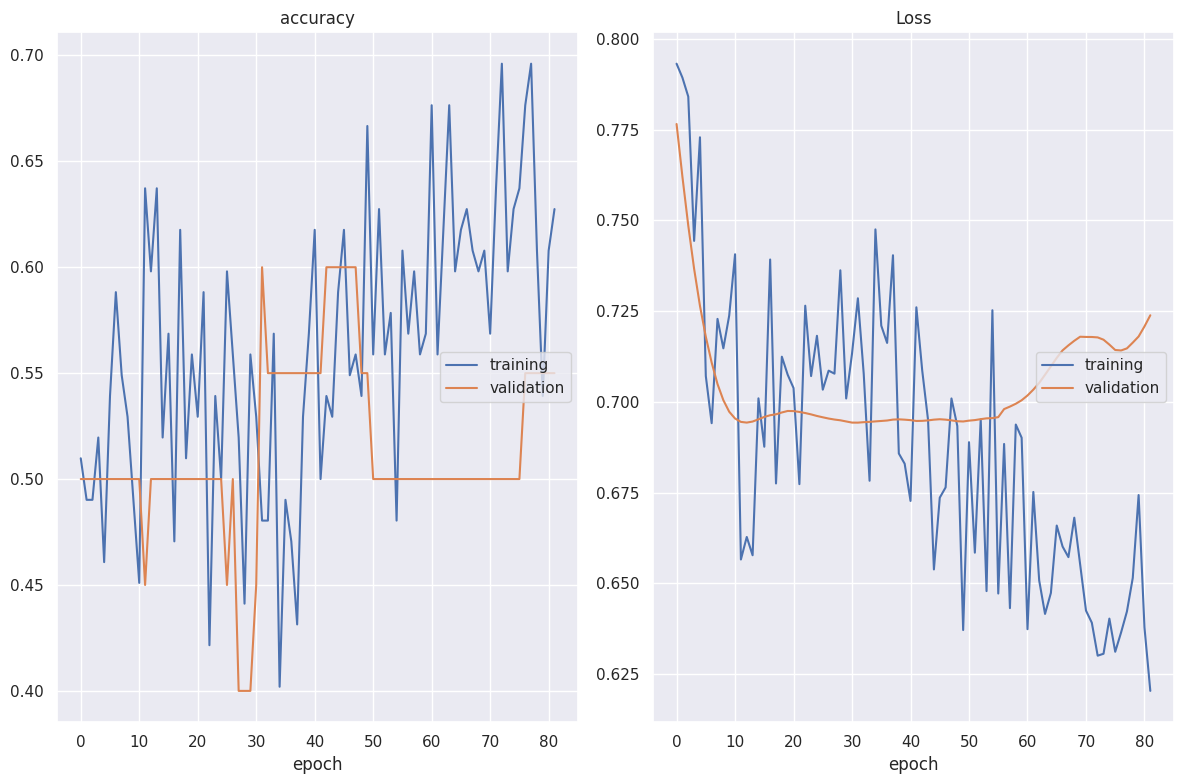

accuracy
	training         	 (min:    0.402, max:    0.696, cur:    0.627)
	validation       	 (min:    0.400, max:    0.600, cur:    0.550)
Loss
	training         	 (min:    0.620, max:    0.793, cur:    0.620)
	validation       	 (min:    0.694, max:    0.777, cur:    0.724)

Epoch 82: val_accuracy did not improve from 0.60000
1/1 [==============================] - 1s 630ms/step - loss: 0.6204 - accuracy: 0.6275 - val_loss: 0.7239 - val_accuracy: 0.5500


In [171]:
model_name = 'model_users_only_150_1_v1_batch_size_250'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.5454545454545454
Precision: [0.57142857 0.53333333]
Recall: 0.7272727272727273
F1 score: 0.615385
ROC AUC: 0.545455


(0.5454545454545454,
 array([0.57142857, 0.53333333]),
 0.7272727272727273,
 0.6153846153846153,
 0.5454545454545454)

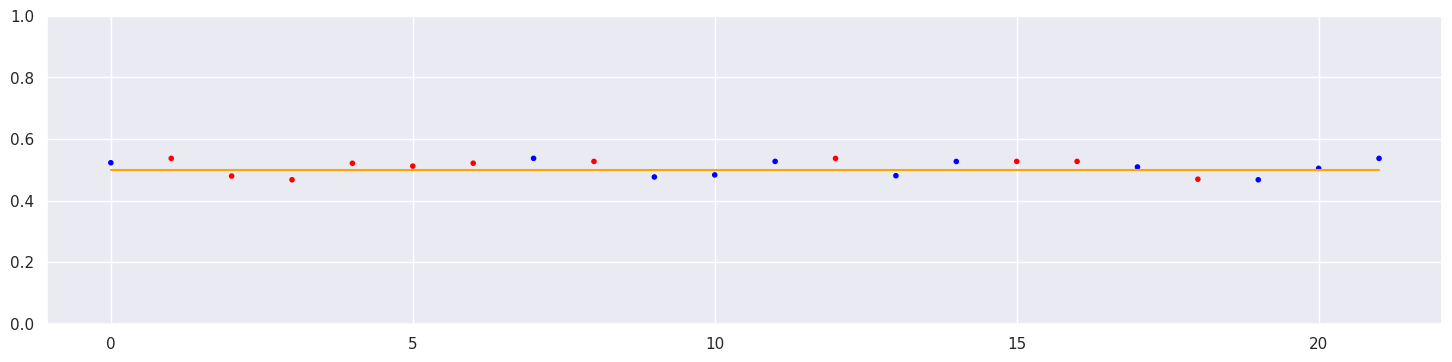

<Figure size 640x480 with 0 Axes>

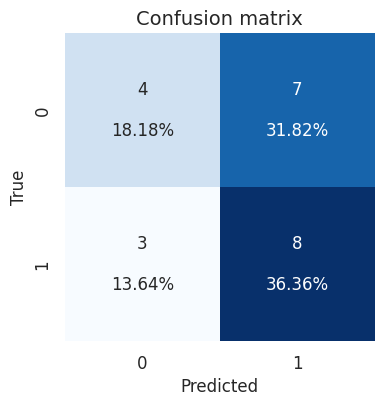

In [172]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=300

#### Create and train model

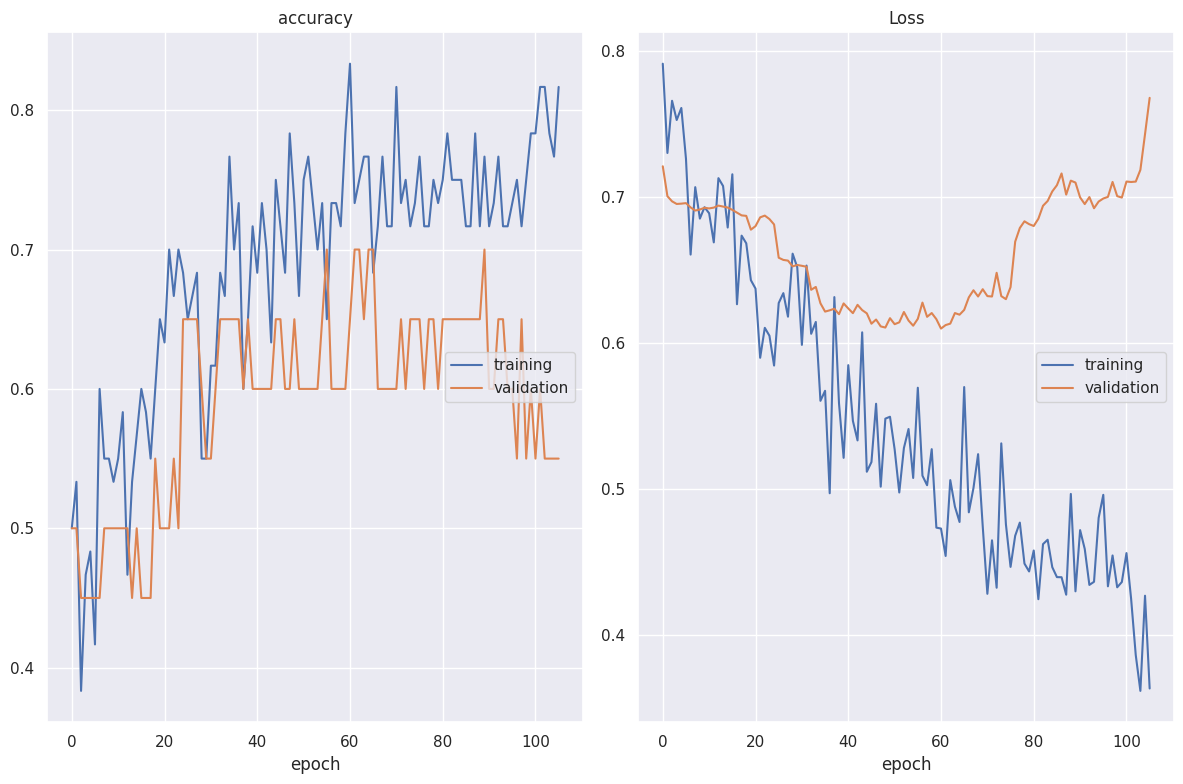

accuracy
	training         	 (min:    0.383, max:    0.833, cur:    0.817)
	validation       	 (min:    0.450, max:    0.700, cur:    0.550)
Loss
	training         	 (min:    0.361, max:    0.791, cur:    0.363)
	validation       	 (min:    0.610, max:    0.768, cur:    0.768)

Epoch 106: val_accuracy did not improve from 0.70000
6/6 [==============================] - 1s 117ms/step - loss: 0.3630 - accuracy: 0.8167 - val_loss: 0.7677 - val_accuracy: 0.5500


In [204]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_10'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.5454545454545454
Precision: [0.52941176 0.6       ]
Recall: 0.2727272727272727
F1 score: 0.375000
ROC AUC: 0.545455


(0.5454545454545454,
 array([0.52941176, 0.6       ]),
 0.2727272727272727,
 0.37499999999999994,
 0.5454545454545454)

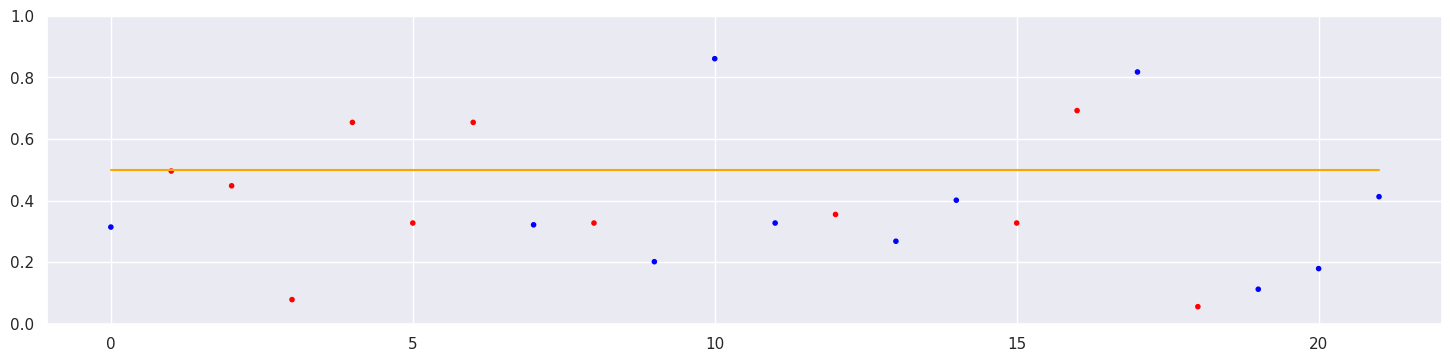

<Figure size 640x480 with 0 Axes>

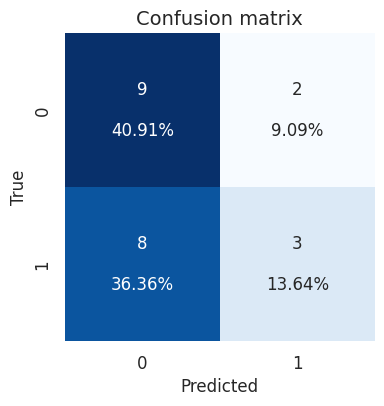

In [205]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=300

#### Create and train model

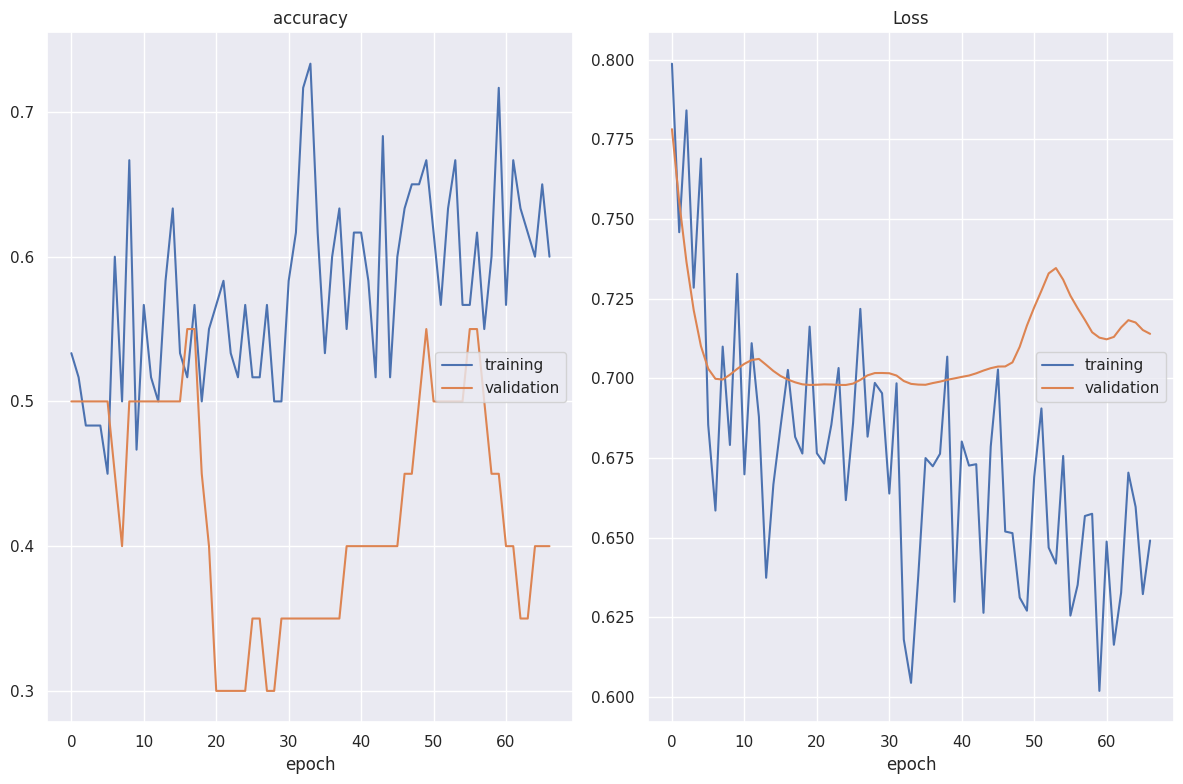

accuracy
	training         	 (min:    0.450, max:    0.733, cur:    0.600)
	validation       	 (min:    0.300, max:    0.550, cur:    0.400)
Loss
	training         	 (min:    0.602, max:    0.799, cur:    0.649)
	validation       	 (min:    0.698, max:    0.778, cur:    0.714)

Epoch 67: val_accuracy did not improve from 0.55000
2/2 [==============================] - 1s 641ms/step - loss: 0.6491 - accuracy: 0.6000 - val_loss: 0.7140 - val_accuracy: 0.4000


In [206]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_50'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=300)

#### Prediction and results

Accuracy: 0.5454545454545454
Precision: [0.66666667 0.52631579]
Recall: 0.9090909090909091
F1 score: 0.666667
ROC AUC: 0.545455


(0.5454545454545454,
 array([0.66666667, 0.52631579]),
 0.9090909090909091,
 0.6666666666666666,
 0.5454545454545454)

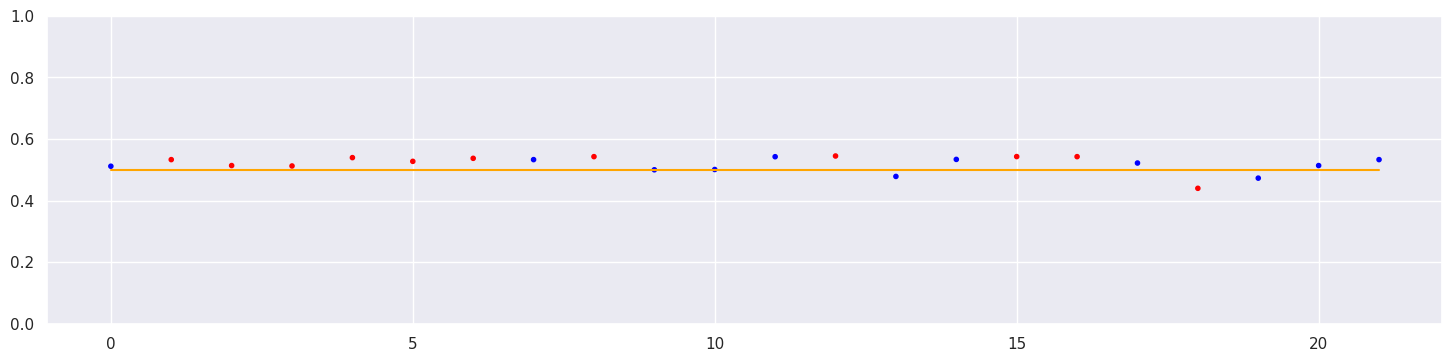

<Figure size 640x480 with 0 Axes>

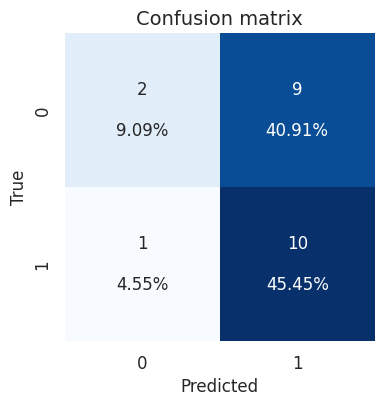

In [207]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=300

#### Create and train model

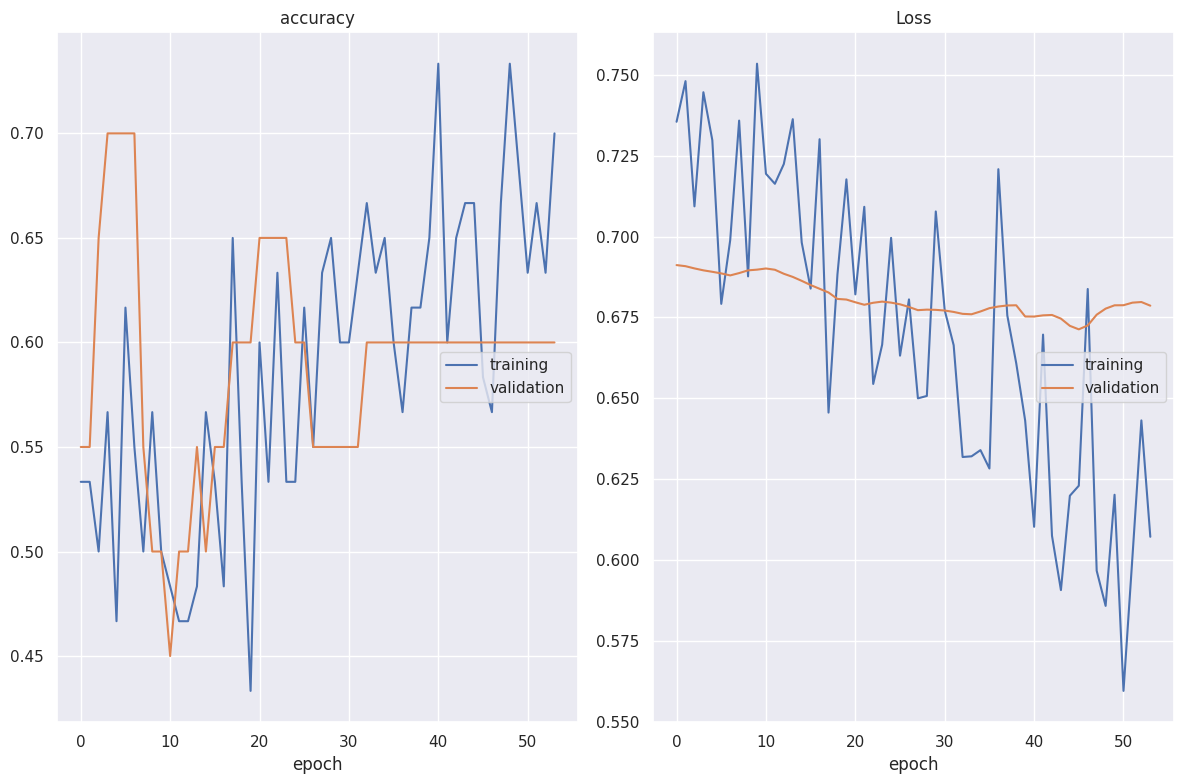

accuracy
	training         	 (min:    0.433, max:    0.733, cur:    0.700)
	validation       	 (min:    0.450, max:    0.700, cur:    0.600)
Loss
	training         	 (min:    0.560, max:    0.753, cur:    0.607)
	validation       	 (min:    0.671, max:    0.691, cur:    0.679)

Epoch 54: val_accuracy did not improve from 0.70000
1/1 [==============================] - 1s 598ms/step - loss: 0.6072 - accuracy: 0.7000 - val_loss: 0.6786 - val_accuracy: 0.6000


In [177]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_100'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.45454545454545453
Precision: [0.46666667 0.42857143]
Recall: 0.2727272727272727
F1 score: 0.333333
ROC AUC: 0.454545


(0.45454545454545453,
 array([0.46666667, 0.42857143]),
 0.2727272727272727,
 0.33333333333333326,
 0.45454545454545453)

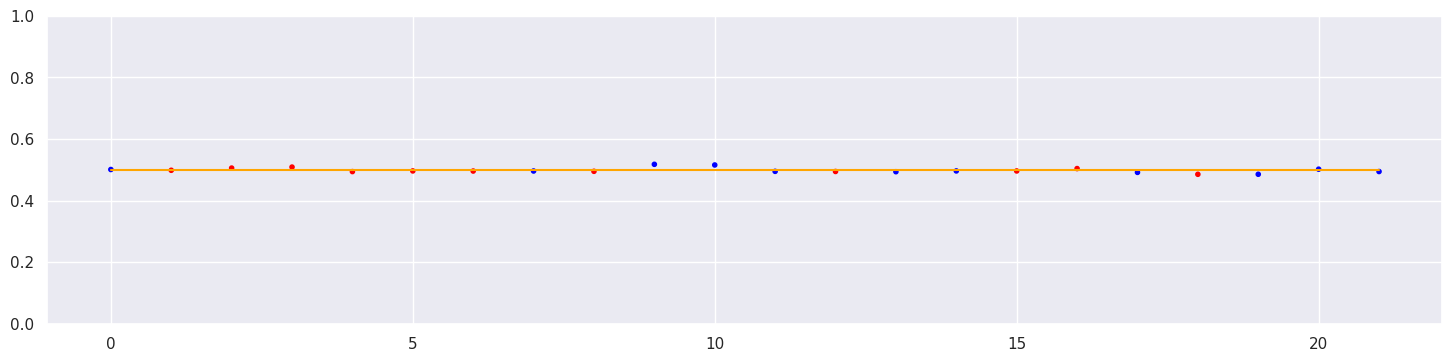

<Figure size 640x480 with 0 Axes>

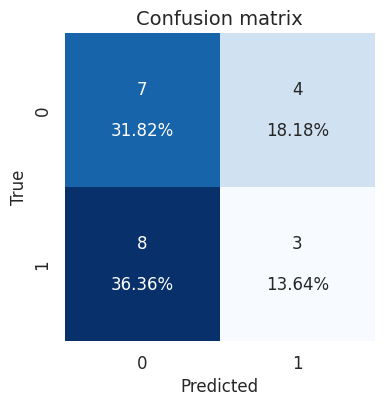

In [178]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=300

#### Create and train model

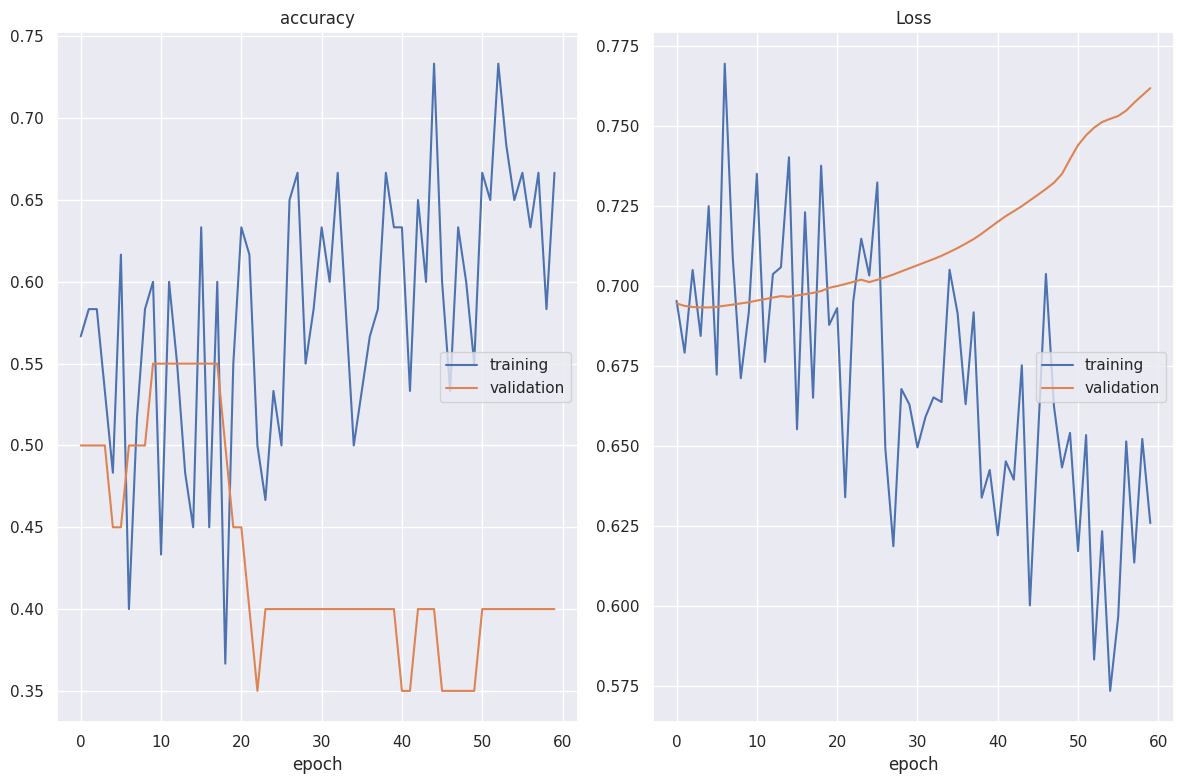

accuracy
	training         	 (min:    0.367, max:    0.733, cur:    0.667)
	validation       	 (min:    0.350, max:    0.550, cur:    0.400)
Loss
	training         	 (min:    0.573, max:    0.770, cur:    0.626)
	validation       	 (min:    0.693, max:    0.762, cur:    0.762)

Epoch 60: val_accuracy did not improve from 0.55000
1/1 [==============================] - 1s 891ms/step - loss: 0.6258 - accuracy: 0.6667 - val_loss: 0.7619 - val_accuracy: 0.4000


In [179]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_150'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.5454545454545454
Precision: [0.57142857 0.53333333]
Recall: 0.7272727272727273
F1 score: 0.615385
ROC AUC: 0.545455


(0.5454545454545454,
 array([0.57142857, 0.53333333]),
 0.7272727272727273,
 0.6153846153846153,
 0.5454545454545454)

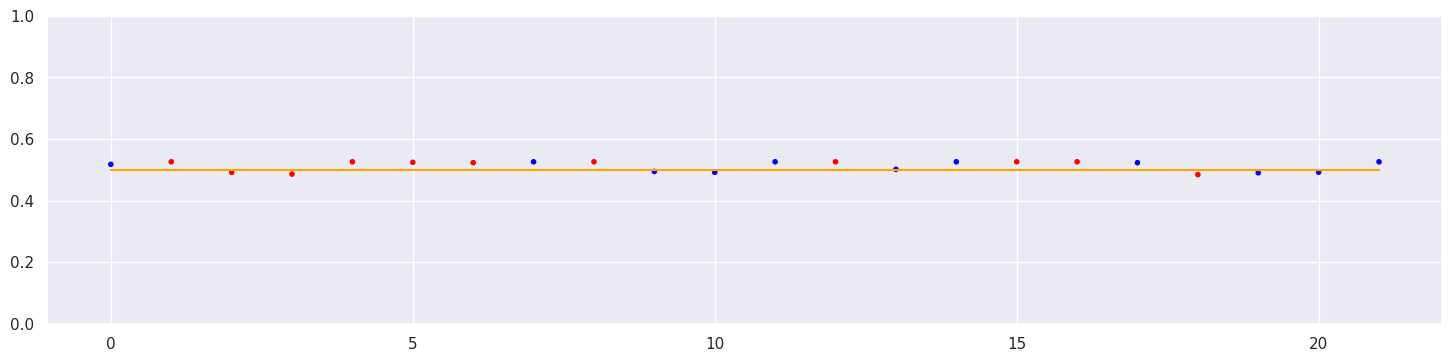

<Figure size 640x480 with 0 Axes>

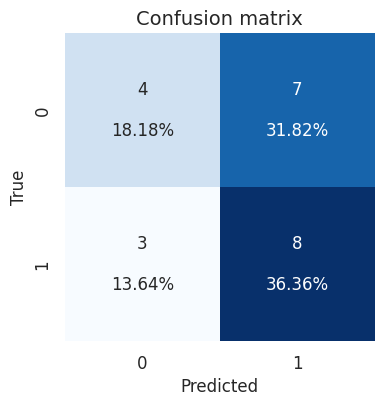

In [180]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=300

#### Create and train model

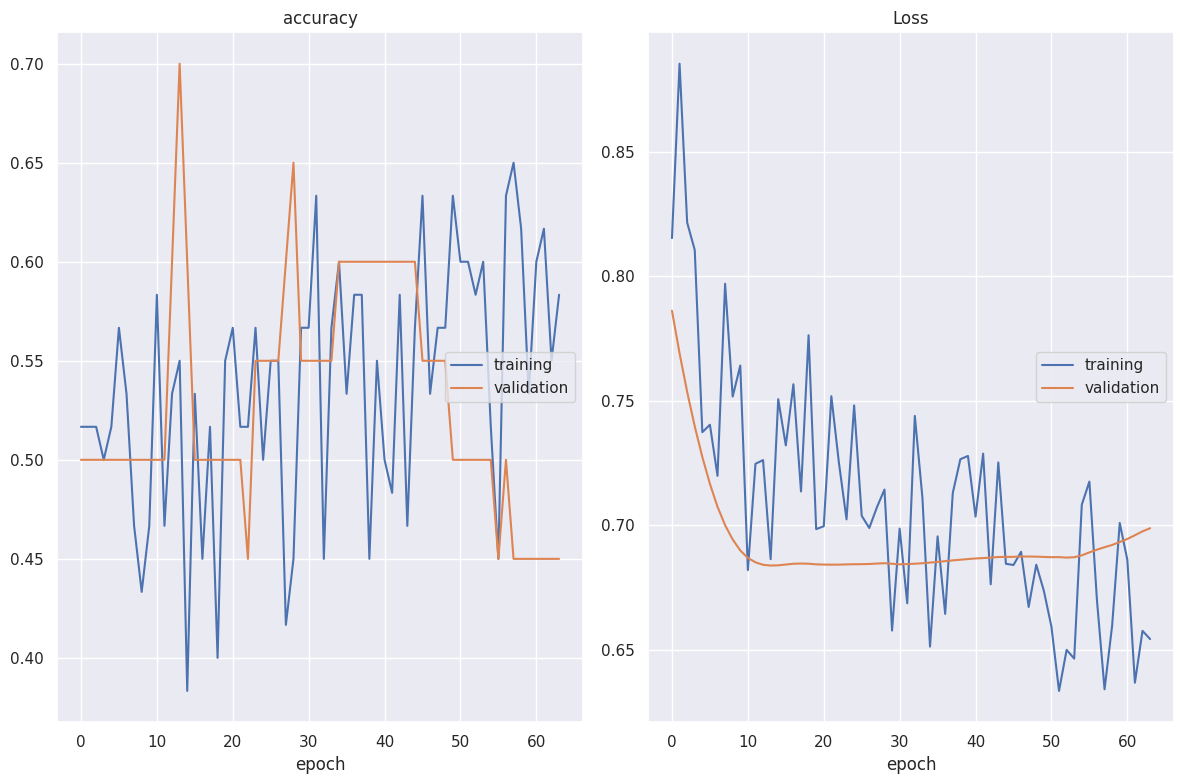

accuracy
	training         	 (min:    0.383, max:    0.650, cur:    0.583)
	validation       	 (min:    0.450, max:    0.700, cur:    0.450)
Loss
	training         	 (min:    0.634, max:    0.885, cur:    0.654)
	validation       	 (min:    0.684, max:    0.786, cur:    0.699)

Epoch 64: val_accuracy did not improve from 0.70000
1/1 [==============================] - 1s 540ms/step - loss: 0.6544 - accuracy: 0.5833 - val_loss: 0.6989 - val_accuracy: 0.4500


In [208]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.4090909090909091
Precision: [0.4375     0.33333333]
Recall: 0.18181818181818182
F1 score: 0.235294
ROC AUC: 0.409091


(0.4090909090909091,
 array([0.4375    , 0.33333333]),
 0.18181818181818182,
 0.23529411764705885,
 0.4090909090909091)

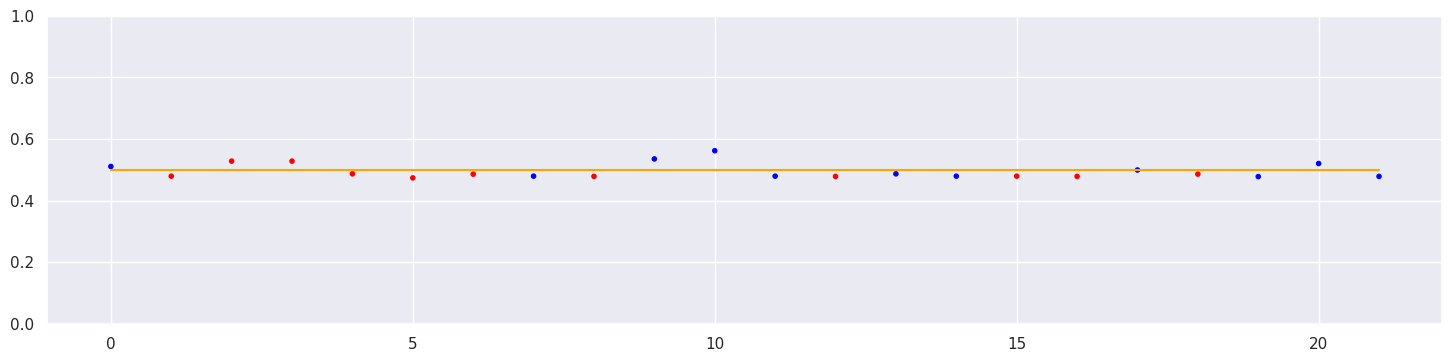

<Figure size 640x480 with 0 Axes>

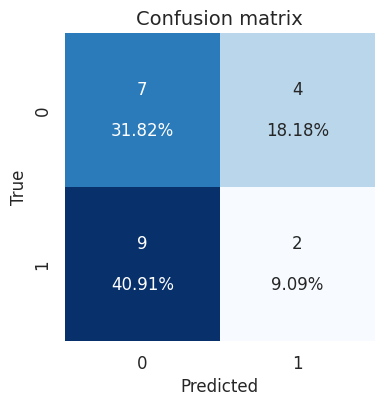

In [209]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=300

#### Create and train model

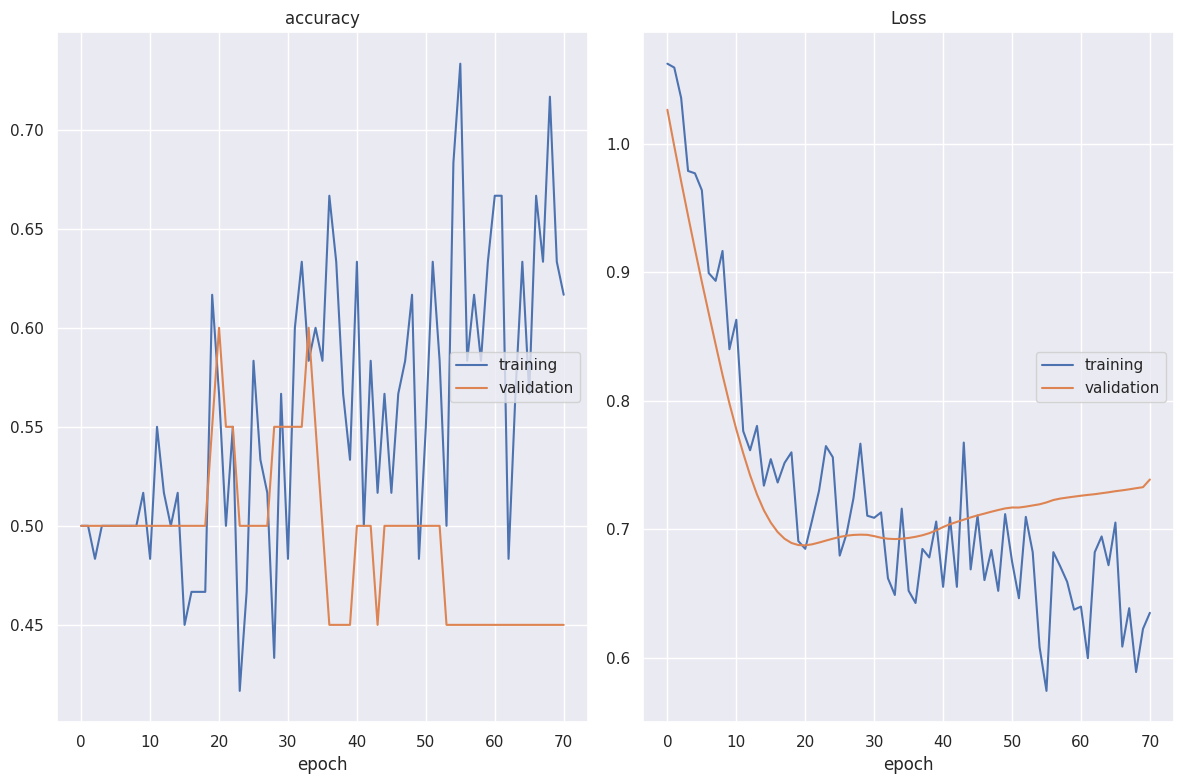

accuracy
	training         	 (min:    0.417, max:    0.733, cur:    0.617)
	validation       	 (min:    0.450, max:    0.600, cur:    0.450)
Loss
	training         	 (min:    0.574, max:    1.063, cur:    0.635)
	validation       	 (min:    0.687, max:    1.027, cur:    0.739)

Epoch 71: val_accuracy did not improve from 0.60000
1/1 [==============================] - 1s 587ms/step - loss: 0.6349 - accuracy: 0.6167 - val_loss: 0.7388 - val_accuracy: 0.4500


In [212]:
model_name = 'model_users_only_150_1_v2_wo_outliers_batch_size_250'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.4090909090909091
Precision: [0.41666667 0.4       ]
Recall: 0.36363636363636365
F1 score: 0.380952
ROC AUC: 0.409091


(0.4090909090909091,
 array([0.41666667, 0.4       ]),
 0.36363636363636365,
 0.380952380952381,
 0.40909090909090917)

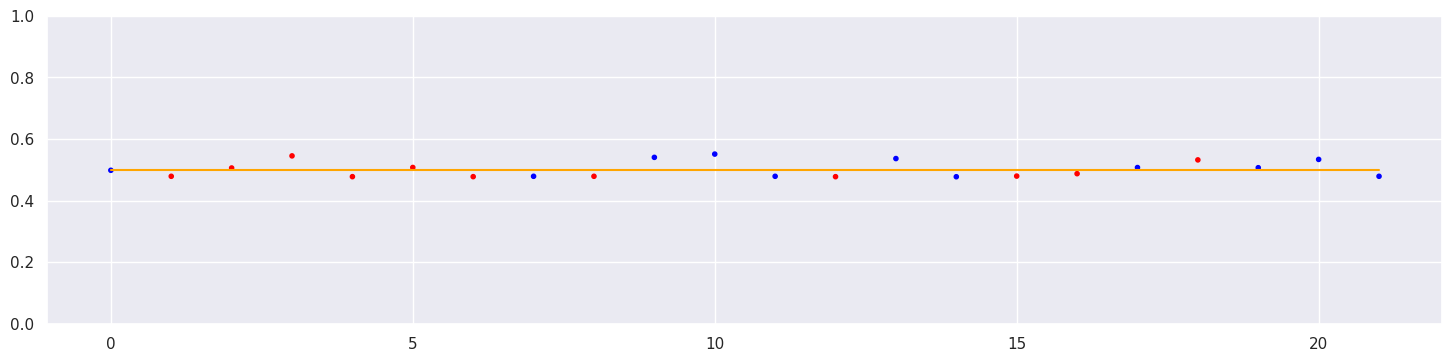

<Figure size 640x480 with 0 Axes>

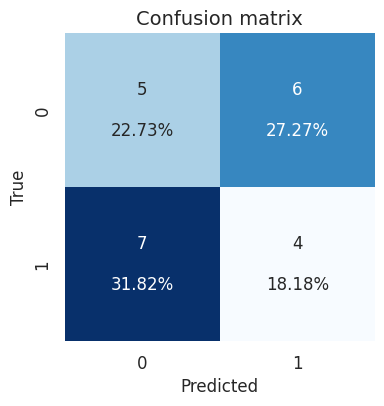

In [213]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)